## 1. Setup and Data Loading

# Data Quality Assessment: Building Energy Dataset

## Dataset Provenance and Credibility

The data used in this analysis originates from the **Building Data Genome Project 2 (BDG2)**, an open dataset published in *Nature Scientific Data* (Miller et al., 2020). The dataset comprises hourly energy meter readings from 3,053 meters across 1,636 non-residential buildings, collected from 19 sites in North America and Europe during 2016–2017.

**Credibility indicators:**

| Indicator | Assessment |
|-----------|------------|
| **Peer review** | Published in *Nature Scientific Data*, a peer-reviewed open-access journal |
| **Institutional backing** | Developed by researchers at National University of Singapore (BUDS Lab), University College Dublin, Princeton University, and others |
| **Open access** | Data and methodology publicly available on GitHub with DOI registration (Zenodo) |

**Citation:**
> Miller, C., Kathirgamanathan, A., Picchetti, B. et al. The Building Data Genome Project 2, energy meter data from the ASHRAE Great Energy Predictor III competition. *Sci Data* 7, 368 (2020). https://doi.org/10.1038/s41597-020-00712-x

## Data Aggregation

The original BDG2 dataset contains hourly meter readings, totalling approximately 17,544 measurements per meter. For this analysis, the hourly data has been aggregated to annual totals for each building-meter combination. The data has been aggregated for energy benchmarking for several reasons: it captures complete heating and cooling cycles, eliminating seasonal bias; it aligns with climate variables such as heating degree days (HDD) and cooling degree days (CDD), which are most meaningful at annual resolution; and it corresponds to the industry-standard Energy Use Intensity metric (EUI, kWh/m²/year) used by ENERGY STAR, ASHRAE, and building rating systems. Aggregation also reduces noise from operational anomalies such as holidays and maintenance shutdowns, and makes clustering computationally tractable by reducing dimensionality from thousands of time points to a single annual value per meter. The trade-off is that temporal patterns—such as peak demand timing and baseload behaviour—are not captured; analyses requiring such granularity should use the original hourly data.

**Temporal note:** The data covers 2016–2017, making it approximately 9–10 years old at the time of this analysis (2026). Building energy patterns may have evolved due to changes in efficiency standards, building codes, occupancy patterns (e.g., post-pandemic hybrid work), and climate conditions.

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load dataset
# Using df_complete.csv as this is the dataset used for clustering in clustering_kprototypes_v1.ipynb
# This dataset already includes all metadata (building_id, sqm, primaryspaceusage, yearbuilt, region, country)
df_complete = pd.read_csv('../data/df_complete.csv')

print(f"Complete dataset shape: {df_complete.shape}")
print(f"\nFeatures in df_complete: {list(df_complete.columns)}")
print("\n" + "="*60)

Complete dataset shape: (5902, 15)

Features in df_complete: ['building_id', 'year', 'meter', 'total_meter_reading', 'site_id', 'sqm', 'primaryspaceusage', 'yearbuilt', 'region', 'country', 'Avg_AirTemp_Annual', 'Total_HDD_Annual', 'Total_CDD_Annual', 'Count_Heating_Days_Annual', 'Count_Cooling_Days_Annual']



In [3]:
# Initial data inspection
print("COMPLETE DATASET - First 5 rows:")
display(df_complete.head())

COMPLETE DATASET - First 5 rows:


,building_id,year,meter,total_meter_reading,site_id,sqm,primaryspaceusage,yearbuilt,region,country,Avg_AirTemp_Annual,Total_HDD_Annual,Total_CDD_Annual,Count_Heating_Days_Annual,Count_Cooling_Days_Annual
0,Bear_assembly_Angel,2016,electricity,3020395.68,Bear,22117.00,Entertainment/public assembly,1933.00,"Berkeley, California",United States of America,15.24,388.22,0.02,146,1
1,Bear_assembly_Angel,2017,electricity,4115350.20,Bear,22117.00,Entertainment/public assembly,1933.00,"Berkeley, California",United States of America,14.97,516.45,8.73,160,4
2,Bear_assembly_Beatrice,2016,electricity,386820.73,Bear,2802.00,Entertainment/public assembly,1958.00,"Berkeley, California",United States of America,15.24,388.22,0.02,146,1
3,Bear_assembly_Beatrice,2017,electricity,365230.06,Bear,2802.00,Entertainment/public assembly,1958.00,"Berkeley, California",United States of America,14.97,516.45,8.73,160,4
4,Bear_assembly_Danial,2016,electricity,561282.44,Bear,7680.30,Entertainment/public assembly,2016.00,"Berkeley, California",United States of America,15.24,388.22,0.02,146,1


In [4]:
# Data types overview
print("COMPLETE DATASET - Data Types:")
print(df_complete.dtypes)
print("\n" + "="*60)

COMPLETE DATASET - Data Types:
building_id                   object
year                           int64
meter                         object
total_meter_reading          float64
site_id                       object
sqm                          float64
primaryspaceusage             object
yearbuilt                    float64
region                        object
country                       object
Avg_AirTemp_Annual           float64
Total_HDD_Annual             float64
Total_CDD_Annual             float64
Count_Heating_Days_Annual      int64
Count_Cooling_Days_Annual      int64
dtype: object



In [5]:
print('\n'+'='*60)

---

## 2. Completeness Analysis

Examines missing data patterns across features and subgroups. Systematic missingness can indicate data access inequities, while random missingness creates technical challenges but doesn't necessarily bias clustering interpretations.

In [6]:
def analyze_completeness(df, dataset_name="Dataset"):
    """Comprehensive completeness analysis for a dataframe."""
    
    print('\n'+'='*60)
    print(f"COMPLETENESS ANALYSIS: {dataset_name}")
    print(f"{'='*60}")
    
    # Calculate missing statistics
    total_rows = len(df)
    missing_counts = df.isnull().sum()
    missing_pct = (missing_counts / total_rows * 100).round(2)
    
    # Create summary dataframe
    completeness_df = pd.DataFrame({
        'Feature': df.columns,
        'Missing Count': missing_counts.values,
        'Missing %': missing_pct.values,
        'Complete Count': total_rows - missing_counts.values,
        'Complete %': (100 - missing_pct).values
    }).sort_values('Missing %', ascending=False)
    
    # Add severity rating
    def severity_rating(pct):
        if pct == 0:
            return '✓ None'
        elif pct < 5:
            return '○ Low'
        elif pct < 20:
            return '△ Moderate'
        elif pct < 50:
            return '▲ High'
        else:
            return '✗ Critical'
    
    completeness_df['Severity'] = completeness_df['Missing %'].apply(severity_rating)
    
    print(f"\nTotal Observations: {total_rows:,}")
    print(f"Complete Cases (all features): {df.dropna().shape[0]:,} ({df.dropna().shape[0]/total_rows*100:.1f}%)")
    print(f"Features with Missing Data: {(missing_counts > 0).sum()} of {len(df.columns)}")
    
    return completeness_df

# Run completeness analysis
completeness_analysis = analyze_completeness(df_complete, "Complete Dataset")
display(completeness_analysis)


COMPLETENESS ANALYSIS: Complete Dataset

Total Observations: 5,902
Complete Cases (all features): 2,726 (46.2%)
Features with Missing Data: 4 of 15


,Feature,Missing Count,Missing %,Complete Count,Complete %,Severity
7,yearbuilt,3121,52.88,2781,47.12,✗ Critical
8,region,1005,17.03,4897,82.97,△ Moderate
9,country,1005,17.03,4897,82.97,△ Moderate
6,primaryspaceusage,55,0.93,5847,99.07,○ Low
0,building_id,0,0.00,5902,100.00,✓ None
1,year,0,0.00,5902,100.00,✓ None
2,meter,0,0.00,5902,100.00,✓ None
3,total_meter_reading,0,0.00,5902,100.00,✓ None
4,site_id,0,0.00,5902,100.00,✓ None
5,sqm,0,0.00,5902,100.00,✓ None


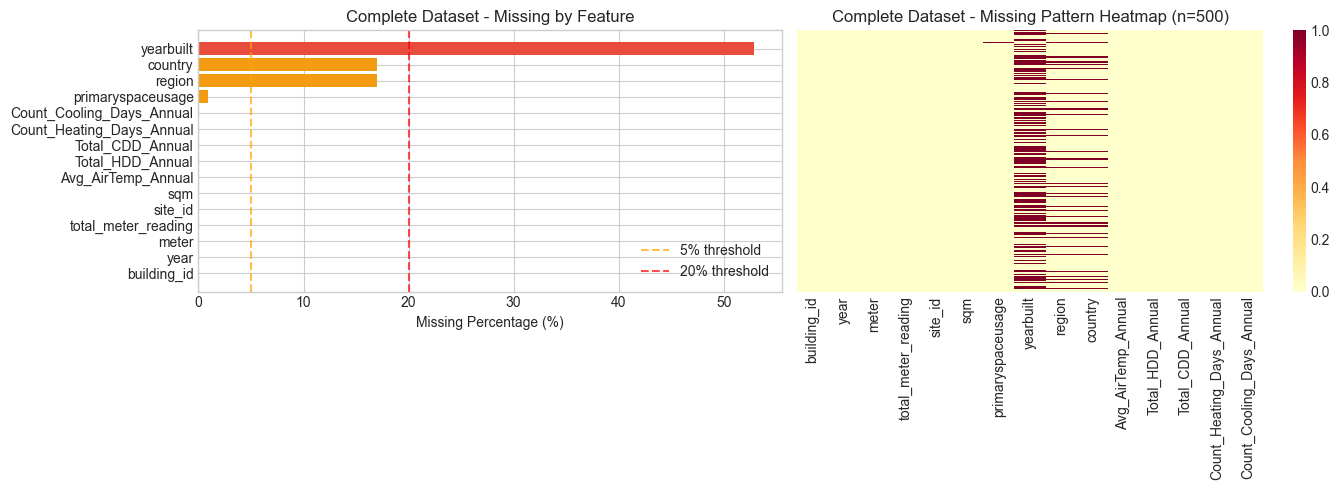

In [7]:
def visualize_missing_data(df, title="Missing Data Pattern"):
    """Create missing data visualizations."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Bar chart of missing percentages
    missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=True)
    colors = ['#2ecc71' if x == 0 else '#e74c3c' if x > 20 else '#f39c12' for x in missing_pct]
    
    axes[0].barh(missing_pct.index, missing_pct.values, color=colors)
    axes[0].set_xlabel('Missing Percentage (%)')
    axes[0].set_title(f'{title} - Missing by Feature')
    axes[0].axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='5% threshold')
    axes[0].axvline(x=20, color='red', linestyle='--', alpha=0.7, label='20% threshold')
    axes[0].legend()
    
    # Right: Heatmap of missing pattern (sample if too large)
    sample_size = min(500, len(df))
    df_sample = df.sample(n=sample_size, random_state=42) if len(df) > sample_size else df
    
    sns.heatmap(df_sample.isnull(), yticklabels=False, cbar=True, cmap='YlOrRd', ax=axes[1])
    axes[1].set_title(f'{title} - Missing Pattern Heatmap (n={sample_size})')
    
    plt.tight_layout()
    plt.show()

visualize_missing_data(df_complete, "Complete Dataset")

---

## 3. Accuracy Validation

Identifies implausible values, measurement errors, and data entry mistakes. Domain knowledge guides accuracy assessment - negative energy consumption indicates errors, while extremely high energy consumption might represent legitimate industrial usage or data collection mistakes requiring investigation.

In [8]:
def detect_outliers(df, method='iqr'):
    """Detect outliers using IQR or Z-score method."""
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    # Exclude 'year' as it's a categorical indicator (2016/2017), not a continuous variable
    numerical_cols = [col for col in numerical_cols if col != 'year']
    outlier_report = {}
    
    for col in numerical_cols:
        data = df[col].dropna()
        
        if method == 'iqr':
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data < lower_bound) | (data > upper_bound)]
        else:  # z-score
            z_scores = np.abs(stats.zscore(data))
            outliers = data[z_scores > 3]
        
        outlier_report[col] = {
            'count': len(outliers),
            'percentage': len(outliers) / len(data) * 100,
            'min_outlier': outliers.min() if len(outliers) > 0 else None,
            'max_outlier': outliers.max() if len(outliers) > 0 else None
        }
    
    return pd.DataFrame(outlier_report).T

# Detect outliers in complete dataset
print("OUTLIER DETECTION (IQR Method)")
print("="*60)
outlier_df = detect_outliers(df_complete, method='iqr')

outlier_df = outlier_df.sort_values('percentage', ascending=False)
display(outlier_df)

OUTLIER DETECTION (IQR Method)


,count,percentage,min_outlier,max_outlier
total_meter_reading,862.00,14.61,7512460.45,24513998933.86
Total_CDD_Annual,608.00,10.30,1438.40,1506.85
sqm,339.00,5.74,26286.50,81290.10
yearbuilt,0.00,0.00,NaN,NaN
Avg_AirTemp_Annual,0.00,0.00,NaN,NaN
Total_HDD_Annual,0.00,0.00,NaN,NaN
Count_Heating_Days_Annual,0.00,0.00,NaN,NaN
Count_Cooling_Days_Annual,0.00,0.00,NaN,NaN


### Detailed Numerical Statistics

Detailed numerical statistics provide a comprehensive profile of each numerical variable beyond basic summary measures. The analysis includes standard descriptive statistics (count, mean, standard deviation, minimum, and maximum) along with percentile values at key thresholds (1%, 5%, 25%, 50%, 75%, 95%, and 99%). These percentiles reveal how values are distributed across the range and help identify potential floor or ceiling effects. Skewness measures the asymmetry of the distribution—positive values indicate a right-skewed distribution with a longer tail toward higher values, while negative values indicate left-skewness. Kurtosis measures the heaviness of the distribution tails compared to a normal distribution—high kurtosis indicates more extreme values than expected. Together, these statistics inform decisions about data transformations (such as log transformation for highly skewed variables) and scaling approaches for clustering algorithms.

In [9]:
# Detailed numerical summary statistics
def detailed_statistics(df):
    """Generate detailed statistics for numerical features."""
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    # Exclude 'year' as it's a categorical indicator (2016/2017), not a continuous variable
    numerical_cols = [col for col in numerical_cols if col != 'year']
    
    stats_dict = {}
    for col in numerical_cols:
        data = df[col].dropna()
        stats_dict[col] = {
            'count': len(data),
            'mean': data.mean(),
            'std': data.std(),
            'min': data.min(),
            '1%': data.quantile(0.01),
            '5%': data.quantile(0.05),
            '25%': data.quantile(0.25),
            '50%': data.median(),
            '75%': data.quantile(0.75),
            '95%': data.quantile(0.95),
            '99%': data.quantile(0.99),
            'max': data.max(),
            'skewness': data.skew(),
            'kurtosis': data.kurtosis()
        }
    
    stats_df = pd.DataFrame(stats_dict).T
    return stats_df

print("DETAILED NUMERICAL STATISTICS")
print("="*60)

detailed_stats = detailed_statistics(df_complete)
display(detailed_stats.round(2))

DETAILED NUMERICAL STATISTICS


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skewness,kurtosis
total_meter_reading,5902.00,96514212.57,757272092.84,0.00,0.00,13490.32,203076.69,769705.25,3126420.00,144847035.46,2528286445.73,24513998933.86,16.50,371.17
sqm,5902.00,9240.33,10316.38,26.30,183.72,597.58,2550.40,6100.30,12029.52,27992.30,51581.81,81290.10,2.74,10.80
yearbuilt,2781.00,1970.14,29.91,1900.00,1903.00,1913.00,1955.00,1975.00,1996.00,2012.00,2016.00,2017.00,-0.51,-0.54
Avg_AirTemp_Annual,5902.00,15.67,5.71,7.53,7.64,9.13,10.85,14.97,21.78,25.21,25.21,25.21,0.40,-1.36
Total_HDD_Annual,5902.00,1381.26,1042.43,58.53,58.53,58.53,310.83,1417.44,2285.00,2958.33,3189.71,3422.98,0.15,-1.31
Total_CDD_Annual,5902.00,332.99,436.85,0.00,0.00,0.00,18.61,160.28,515.44,1506.85,1506.85,1506.85,1.71,1.94
Count_Heating_Days_Annual,5902.00,161.12,86.83,20.00,20.00,20.00,65.00,179.00,235.00,274.00,315.00,315.00,-0.32,-1.33
Count_Cooling_Days_Annual,5902.00,82.62,70.88,0.00,0.00,0.00,14.00,63.00,155.00,201.00,201.00,201.00,0.37,-1.39


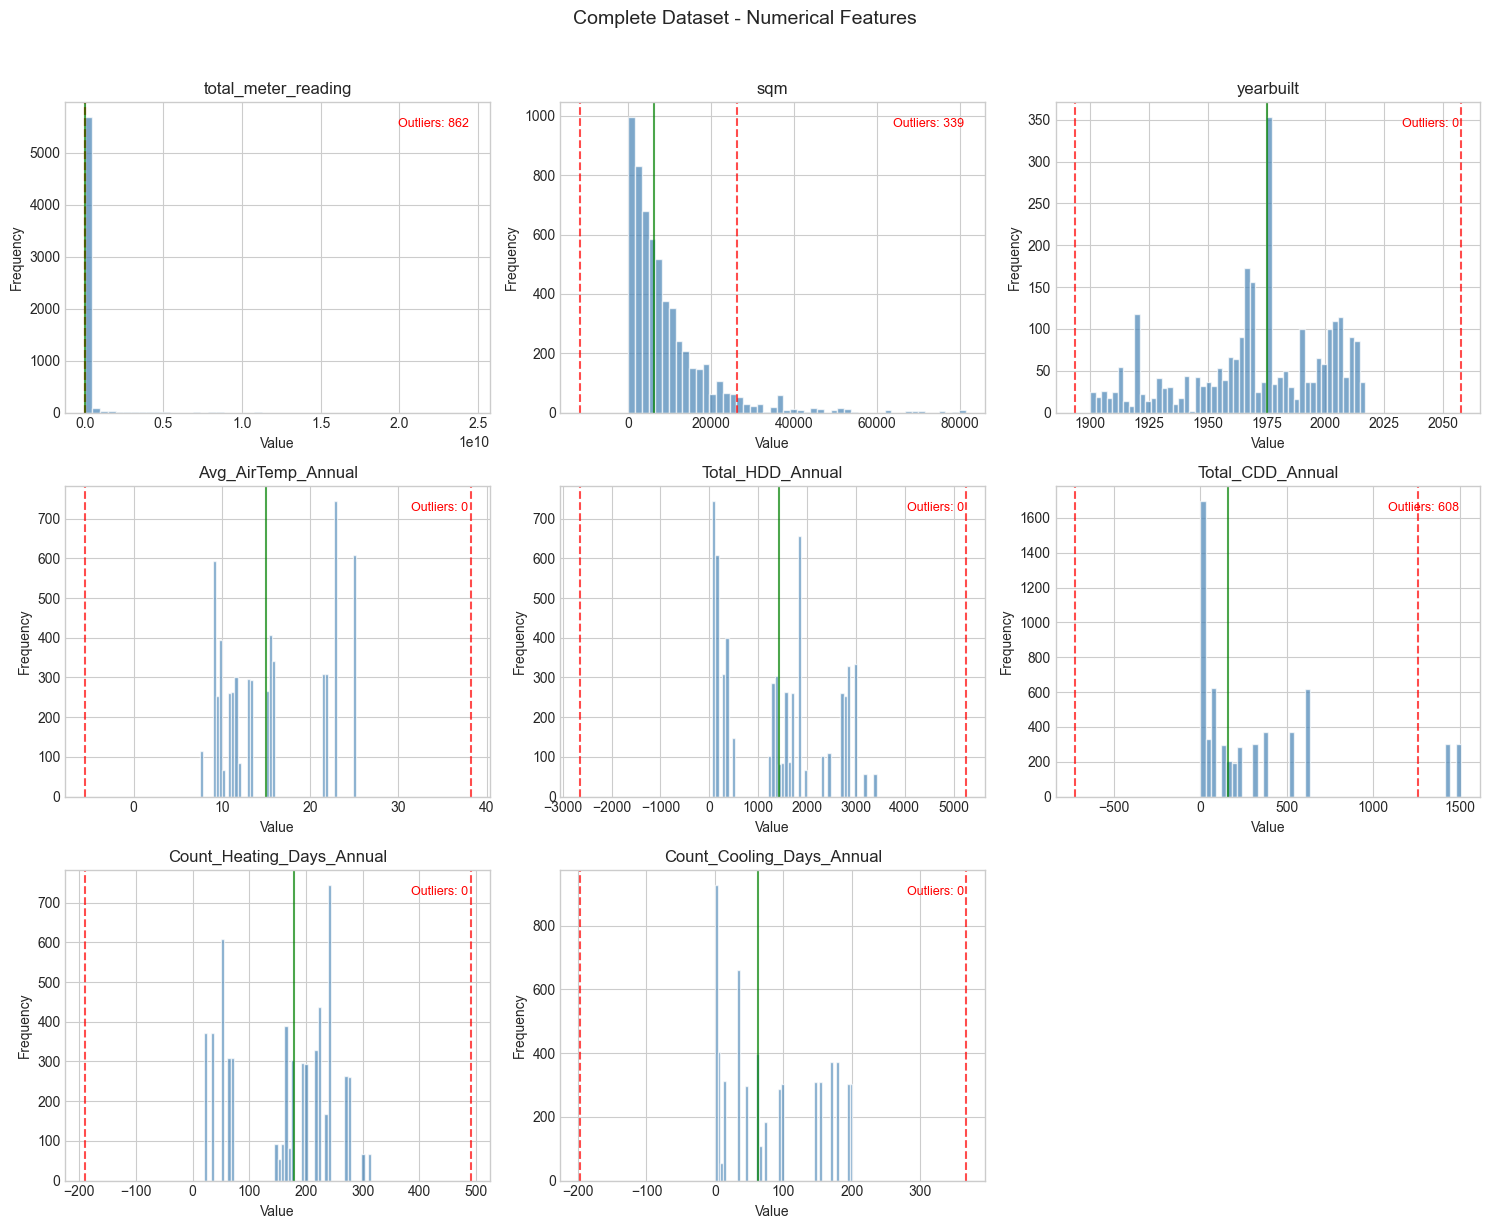

In [10]:
def visualize_distributions(df, title="Distribution Analysis"):
    """Create distribution plots for numerical variables with outlier highlighting."""
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    # Exclude 'year' as it's a categorical indicator (2016/2017), not a continuous variable
    numerical_cols = [col for col in numerical_cols if col != 'year']
    n_cols = len(numerical_cols)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
    axes = axes.ravel() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for i, col in enumerate(numerical_cols):
        data = df[col].dropna()
        
        # Calculate IQR bounds
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Create histogram
        axes[i].hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
        axes[i].axvline(x=lower_bound, color='red', linestyle='--', alpha=0.7, label='IQR bounds')
        axes[i].axvline(x=upper_bound, color='red', linestyle='--', alpha=0.7)
        axes[i].axvline(x=data.median(), color='green', linestyle='-', alpha=0.7, label='Median')
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        
        # Add outlier count annotation
        outlier_count = ((data < lower_bound) | (data > upper_bound)).sum()
        axes[i].annotate(f'Outliers: {outlier_count}', xy=(0.95, 0.95), 
                        xycoords='axes fraction', ha='right', va='top',
                        fontsize=9, color='red')
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle(f'{title} - Numerical Features', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

visualize_distributions(df_complete, "Complete Dataset")

### Box Plot Visualization

Box plots provide a compact visual summary of how values are distributed for each numerical variable. The box itself represents the middle 50% of the data, with the line inside the box marking the median (the middle value). The "whiskers" extending from the box show the range of typical values. Points appearing beyond the whiskers are potential outliers—values that fall unusually far from the rest of the data. Variables with many outliers or very long whiskers may require special handling before clustering, such as capping extreme values or applying mathematical transformations to reduce the influence of unusual observations.

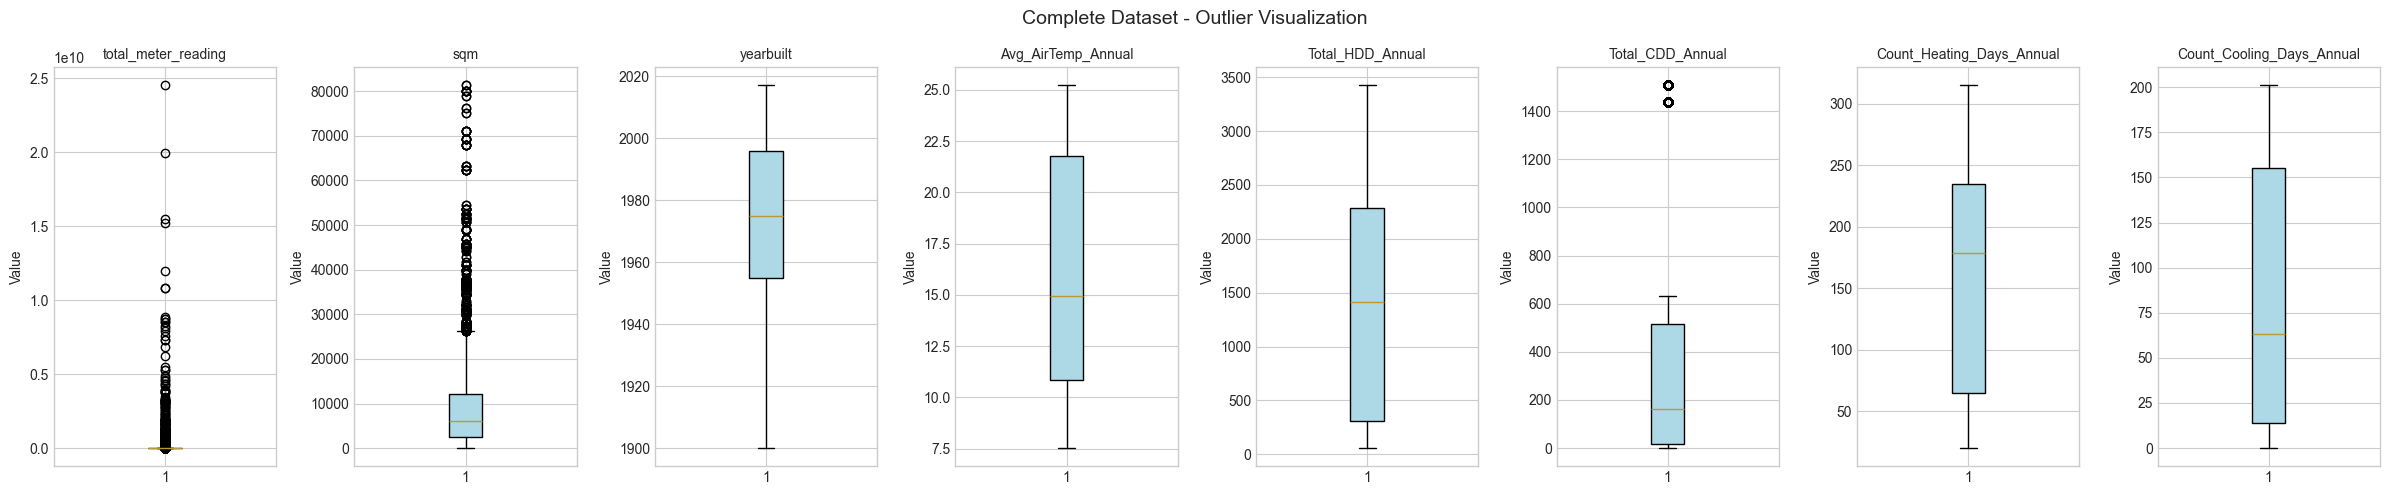

In [11]:
# Box plots for outlier visualization
def create_boxplots(df, title="Box Plots"):
    """Create box plots for numerical features."""
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    # Exclude 'year' as it's a categorical indicator (2016/2017), not a continuous variable
    numerical_cols = [col for col in numerical_cols if col != 'year']
    n_cols = len(numerical_cols)
    
    fig, axes = plt.subplots(1, n_cols, figsize=(3*n_cols, 5))
    if n_cols == 1:
        axes = [axes]
    
    for i, col in enumerate(numerical_cols):
        data = df[col].dropna()
        bp = axes[i].boxplot(data, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        axes[i].set_title(col, fontsize=10)
        axes[i].set_ylabel('Value')
    
    plt.suptitle(f'{title} - Outlier Visualization', fontsize=14)
    plt.tight_layout()
    plt.show()

create_boxplots(df_complete, "Complete Dataset")

### Distribution Analysis Summary

**Key observations from the distribution analysis and box plots:**

- **total_meter_reading**: Extremely right-skewed distribution (skewness = 16.50, kurtosis = 371.17) with 14.6% of values identified as outliers. Values range from 0 to over 24 billion, with extreme variation between buildings. The median (769,705) is far below the mean (96.5 million), indicating a small number of very high-consumption buildings pulling the average upward.
- **sqm** (floor area): Right-skewed distribution (skewness = 2.74) with 5.7% outliers. Building sizes range from 26 to 81,290 square meters, with most buildings clustering between 2,550 and 12,030 sqm (interquartile range). Larger buildings above 26,000 sqm are flagged as outliers.
- **yearbuilt**: Slightly left-skewed distribution (skewness = -0.51) with no statistical outliers. Buildings span from 1900 to 2017, with a median construction year of 1975. Approximately 47% of records have missing yearbuilt data.
- **Climate variables (HDD, CDD, temperature)**: Total_CDD_Annual shows moderate right-skewness (1.71) with 10.3% outliers representing hot climate locations. HDD and temperature variables show no outliers by IQR criteria. All climate variables exhibit negative kurtosis, indicating relatively flat distributions across climate zones.

**Implications for clustering:**
- **total_meter_reading** and **sqm** require log transformation or robust scaling due to extreme right-skewness, as standard scaling would be heavily influenced by outliers.
- Consider using RobustScaler instead of StandardScaler for variables with high outlier percentages (total_meter_reading, Total_CDD_Annual, sqm).
- The extreme values in total_meter_reading (up to 24.5 billion) should be investigated to determine whether they represent legitimate high-consumption facilities or data aggregation errors.

### Log Transformation Analysis

Log transformation is a standard technique for handling right-skewed distributions in numerical data. By compressing the scale of large values while spreading out smaller values, log transformation can reduce the influence of extreme outliers and make distributions more symmetric (closer to normal). This is particularly important for clustering algorithms, which often assume or perform better with roughly symmetric distributions.

For building energy data, log transformation is especially appropriate for `total_meter_reading` and `sqm` because:
- Both variables span several orders of magnitude (from tens to billions for energy, from tens to tens of thousands for floor area)
- The relationship between building size and energy consumption is often multiplicative rather than additive
- Extreme values represent legitimate variation (large industrial facilities, campus buildings) rather than errors

The following analysis applies log transformation to these variables and compares the resulting distributions to the original data.

LOG TRANSFORMATION ANALYSIS


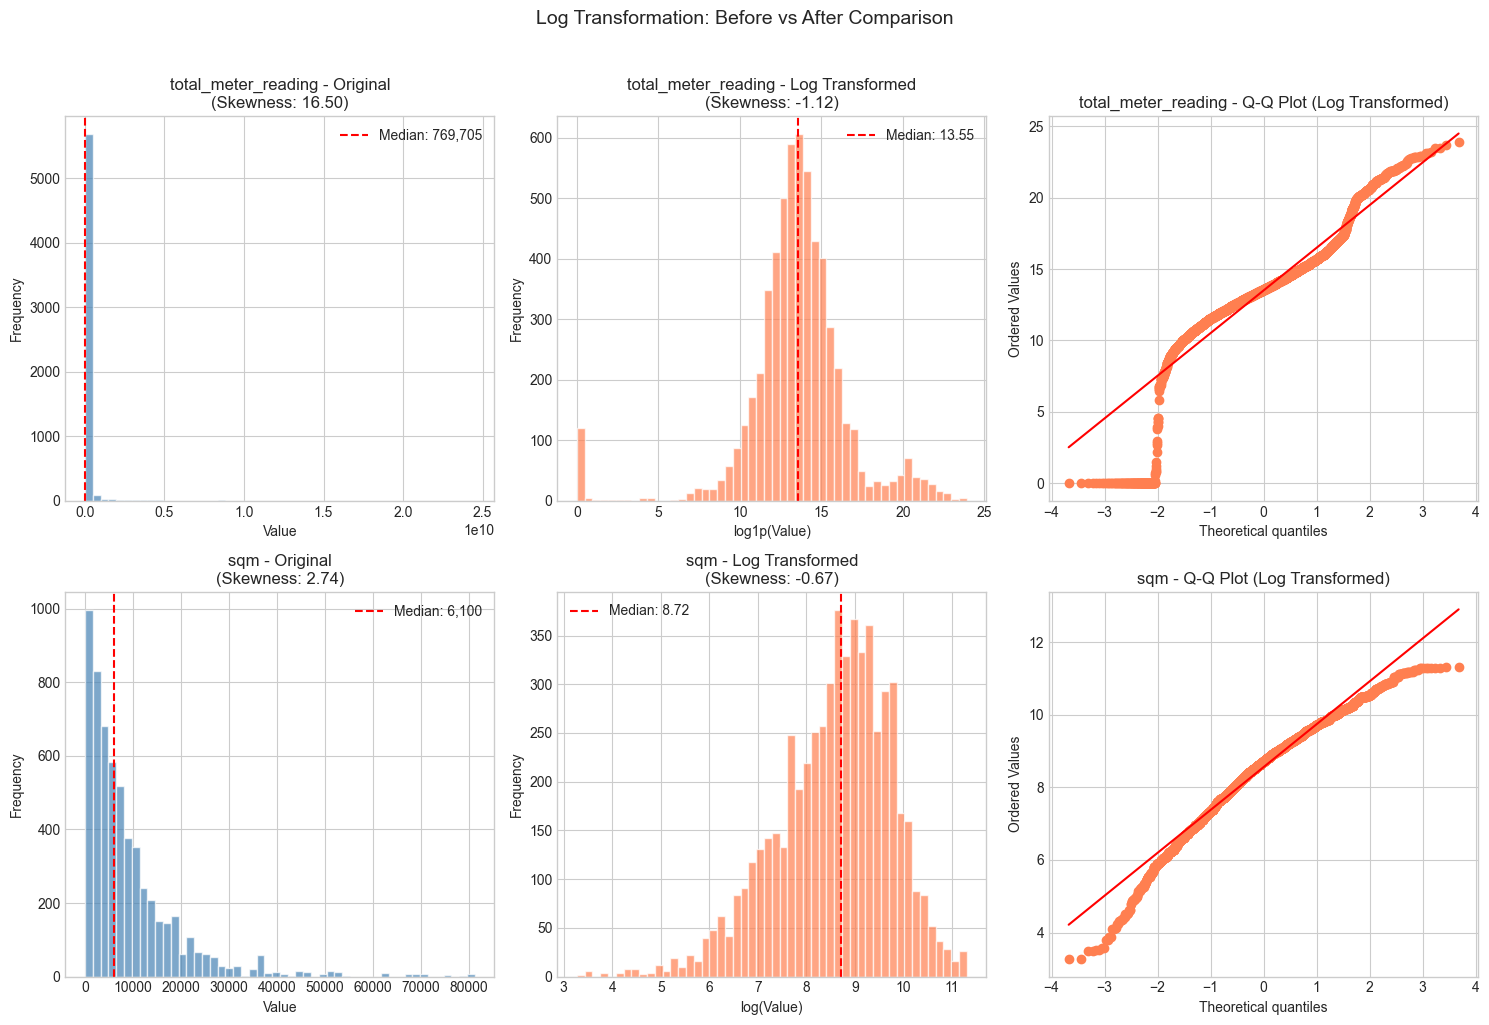


Transformation Statistics Comparison:


,Variable,Transform,Mean,Median,Std,Skewness,Kurtosis
0,total_meter_reading,Original,96514212.57,769705.25,757272092.84,16.50,371.17
1,total_meter_reading,log1p,13.51,13.55,3.20,-1.12,5.79
2,sqm,Original,9240.33,6100.30,10316.38,2.74,10.80
3,sqm,log,8.56,8.72,1.20,-0.67,0.70



Outlier Analysis (IQR Method):
  total_meter_reading:
    Original: 862 outliers (14.6%)
    Log-transformed: 479 outliers (8.1%)
  sqm:
    Original: 339 outliers (5.7%)
    Log-transformed: 84 outliers (1.4%)


In [12]:
# Log transformation analysis for skewed variables
def analyze_log_transformation(df, columns=['total_meter_reading', 'sqm']):
    """Apply and visualize log transformation for skewed variables."""
    
    print("LOG TRANSFORMATION ANALYSIS")
    print("="*60)
    
    fig, axes = plt.subplots(len(columns), 3, figsize=(15, 5*len(columns)))
    if len(columns) == 1:
        axes = axes.reshape(1, -1)
    
    transformation_stats = []
    
    for i, col in enumerate(columns):
        if col not in df.columns:
            print(f"Column {col} not found")
            continue
            
        data = df[col].dropna()
        
        # Handle zero or negative values for log transformation
        if (data <= 0).any():
            # Use log1p (log(1+x)) for data with zeros
            data_log = np.log1p(data)
            transform_type = 'log1p'
        else:
            data_log = np.log(data)
            transform_type = 'log'
        
        # Calculate statistics before and after
        stats_before = {
            'Variable': col,
            'Transform': 'Original',
            'Mean': data.mean(),
            'Median': data.median(),
            'Std': data.std(),
            'Skewness': data.skew(),
            'Kurtosis': data.kurtosis()
        }
        
        stats_after = {
            'Variable': col,
            'Transform': f'{transform_type}',
            'Mean': data_log.mean(),
            'Median': data_log.median(),
            'Std': data_log.std(),
            'Skewness': data_log.skew(),
            'Kurtosis': data_log.kurtosis()
        }
        
        transformation_stats.extend([stats_before, stats_after])
        
        # Plot original distribution
        axes[i, 0].hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
        axes[i, 0].axvline(x=data.median(), color='red', linestyle='--', label=f'Median: {data.median():,.0f}')
        axes[i, 0].set_title(f'{col} - Original\n(Skewness: {data.skew():.2f})')
        axes[i, 0].set_xlabel('Value')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].legend()
        
        # Plot log-transformed distribution
        axes[i, 1].hist(data_log, bins=50, alpha=0.7, color='coral', edgecolor='white')
        axes[i, 1].axvline(x=data_log.median(), color='red', linestyle='--', label=f'Median: {data_log.median():.2f}')
        axes[i, 1].set_title(f'{col} - Log Transformed\n(Skewness: {data_log.skew():.2f})')
        axes[i, 1].set_xlabel(f'{transform_type}(Value)')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].legend()
        
        # Q-Q plot to assess normality after transformation
        from scipy import stats as scipy_stats
        scipy_stats.probplot(data_log, dist="norm", plot=axes[i, 2])
        axes[i, 2].set_title(f'{col} - Q-Q Plot (Log Transformed)')
        axes[i, 2].get_lines()[0].set_markerfacecolor('coral')
        axes[i, 2].get_lines()[0].set_markeredgecolor('coral')
    
    plt.suptitle('Log Transformation: Before vs After Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Display comparison statistics
    stats_df = pd.DataFrame(transformation_stats)
    print("\nTransformation Statistics Comparison:")
    display(stats_df.round(2))
    
    # Calculate outlier reduction
    print("\nOutlier Analysis (IQR Method):")
    for col in columns:
        if col not in df.columns:
            continue
        data = df[col].dropna()
        data_log = np.log1p(data) if (data <= 0).any() else np.log(data)
        
        # Original outliers
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers_orig = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        
        # Log-transformed outliers
        Q1_log, Q3_log = data_log.quantile([0.25, 0.75])
        IQR_log = Q3_log - Q1_log
        outliers_log = ((data_log < Q1_log - 1.5*IQR_log) | (data_log > Q3_log + 1.5*IQR_log)).sum()
        
        print(f"  {col}:")
        print(f"    Original: {outliers_orig} outliers ({outliers_orig/len(data)*100:.1f}%)")
        print(f"    Log-transformed: {outliers_log} outliers ({outliers_log/len(data)*100:.1f}%)")
    
    return stats_df

# Apply log transformation analysis
log_transform_stats = analyze_log_transformation(df_complete, ['total_meter_reading', 'sqm'])

In the Q-graphs, the orange dots curve away from the straight red line. This means the data is not normally distributed. Essentially, these plots show that the measured values for "total_meter_reading" and "sqm" do not naturally follow a standard bell curve pattern, even after trying to adjust them with a log transformation. 


### Domain-Specific Validation

Domain-specific validation applies expert knowledge about building energy data to identify values that are technically possible but practically implausible. Energy meter readings and climate metrics such as Heating Degree Days, Cooling Degree Days, and day counts should always be non-negative, as negative values have no physical meaning in these contexts. Building floor area (measured in square meters) should fall within reasonable bounds—extremely small values may indicate data entry errors or unusual utility spaces, while exceptionally large values might represent campus-level aggregations rather than individual buildings. Construction year (yearbuilt) should not extend into the future, and buildings recorded as built before a certain threshold, e.g. 1850 warrant verification as they may represent historical landmarks or data errors. Annual average temperature values outside the range of -30°C to 40°C are unusual for occupied building locations and suggest potential issues with weather data alignment. Identifying these domain-specific anomalies helps distinguish between genuine outliers and data quality problems that require correction before analysis.

In [13]:
# Domain-specific validation for energy/climate data
def validate_energy_data(df):
    """Validate energy- and climate-related data for domain-specific issues."""
    
    issues = []
    
    # Check energy/climate columns for negative values (these should all be non-negative)
    non_negative_cols = ['total_meter_reading', 'Total_HDD_Annual', 'Total_CDD_Annual', 
                         'Count_Heating_Days_Annual', 'Count_Cooling_Days_Annual']
    
    for col in non_negative_cols:
        if col in df.columns:
            negatives = (df[col] < 0).sum()
            if negatives > 0:
                issues.append({
                    'Feature': col,
                    'Issue': 'Negative values',
                    'Count': negatives,
                    'Severity': 'Critical',
                    'Action': 'Investigate - values should be non-negative'
                })
    
    # Check sqm (floor area) for implausible values
    if 'sqm' in df.columns:
        very_small = (df['sqm'] < 10).sum()
        very_large = (df['sqm'] > 100000).sum()
        
        if very_small > 0:
            issues.append({
                'Feature': 'sqm',
                'Issue': 'Very small area (<10 sqm)',
                'Count': very_small,
                'Severity': 'Warning',
                'Action': 'Verify - may be utility rooms or data errors'
            })
        
        if very_large > 0:
            issues.append({
                'Feature': 'sqm',
                'Issue': 'Very large area (>100,000 sqm)',
                'Count': very_large,
                'Severity': 'Warning',
                'Action': 'Verify - may be campus-level aggregation or data errors'
            })
    
    # Check year built for future dates or implausible past dates
    if 'yearbuilt' in df.columns:
        current_year = 2026
        yearbuilt_data = df['yearbuilt'].dropna()
        future = (yearbuilt_data > current_year).sum()
        very_old = (yearbuilt_data < 1800).sum()
        
        if future > 0:
            issues.append({
                'Feature': 'yearbuilt',
                'Issue': 'Future year built',
                'Count': future,
                'Severity': 'Critical',
                'Action': 'Data entry error - correct or remove'
            })
        
        if very_old > 0:
            issues.append({
                'Feature': 'yearbuilt',
                'Issue': 'Year built before 1800',
                'Count': very_old,
                'Severity': 'Warning',
                'Action': 'Verify historical buildings'
            })
    
    # Check temperature values for plausibility
    if 'Avg_AirTemp_Annual' in df.columns:
        temp_data = df['Avg_AirTemp_Annual'].dropna()
        extreme_cold = (temp_data < -30).sum()
        extreme_hot = (temp_data > 40).sum()
        
        if extreme_cold > 0:
            issues.append({
                'Feature': 'Avg_AirTemp_Annual',
                'Issue': 'Extremely cold annual avg (<-30°C)',
                'Count': extreme_cold,
                'Severity': 'Warning',
                'Action': 'Verify - unusual for building locations'
            })
        
        if extreme_hot > 0:
            issues.append({
                'Feature': 'Avg_AirTemp_Annual',
                'Issue': 'Extremely hot annual avg (>40°C)',
                'Count': extreme_hot,
                'Severity': 'Warning',
                'Action': 'Verify - unusual for annual average'
            })
    
    if issues:
        return pd.DataFrame(issues)
    else:
        print("No domain-specific issues detected!")
        return None

print("DOMAIN-SPECIFIC VALIDATION (Energy Data)")
print("="*60)
validation_issues = validate_energy_data(df_complete)
if validation_issues is not None:
    display(validation_issues)
else:
    print("✓ All domain validations passed")

DOMAIN-SPECIFIC VALIDATION (Energy Data)
No domain-specific issues detected!
✓ All domain validations passed


---

## 4. Consistency Checking

Consistency checking determines whether related measurements in the dataset make sense when compared to one another. In building energy data, certain variables have predictable relationships based on physical and climatic principles. Heating Degree Days (HDD) measure how much heating a building likely requires, while Cooling Degree Days (CDD) measure cooling demand. Locations with cold winters tend to have high HDD but low CDD, whereas hot climates show the opposite pattern. A strong positive correlation between HDD and CDD would be unexpected and may signal data quality problems. Similarly, a building's recorded construction year should not exceed the year when energy measurements were taken. Energy meter readings, which represent consumption values, should never be negative. When these expected relationships fail to hold, the data may contain collection errors, incorrect merging of records from different sources, or sensor malfunctions that require investigation before proceeding with analysis.

CORRELATION ANALYSIS


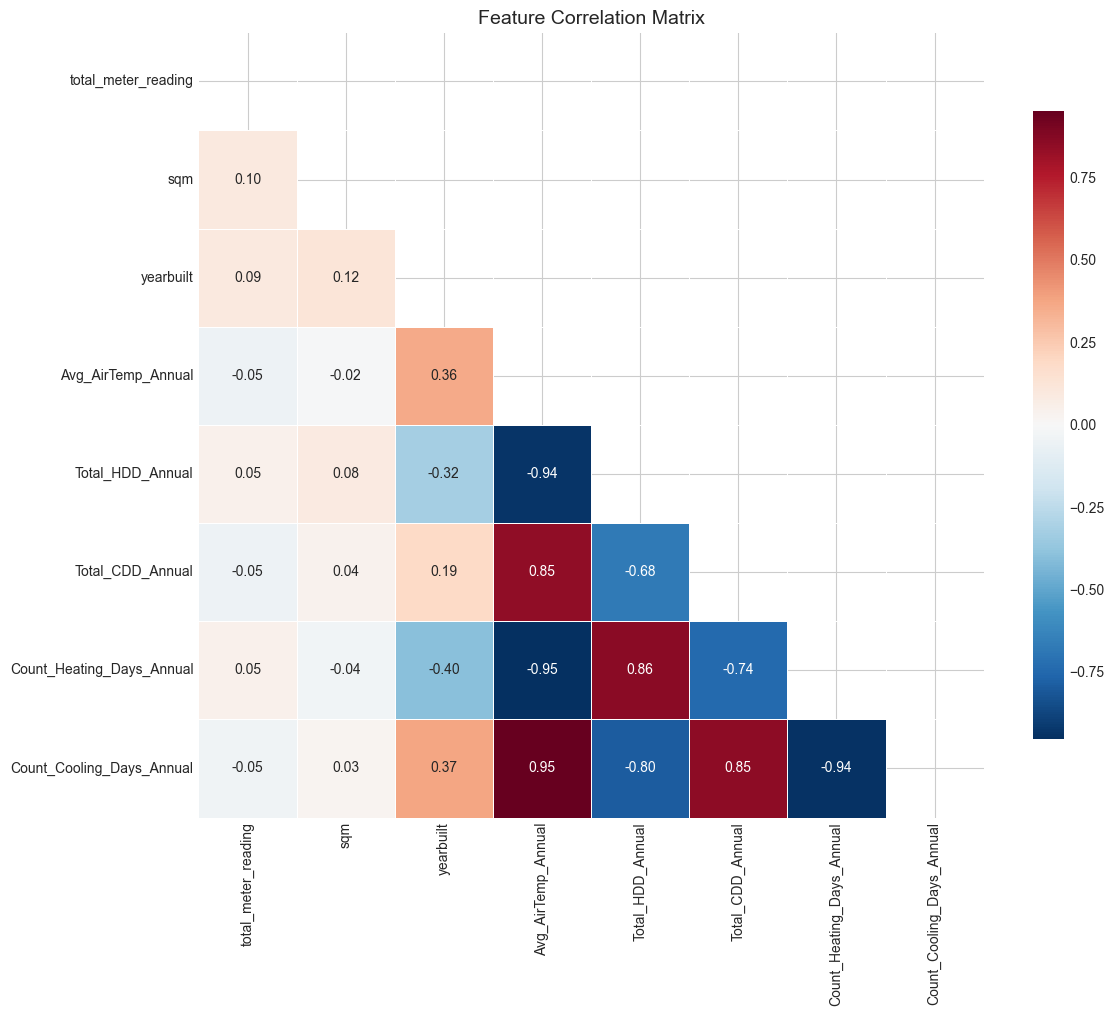

In [14]:
# Correlation analysis for logical consistency
def analyze_correlations(df):
    """Analyze correlations between numerical variables for consistency checking."""
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    # Exclude 'year' as it's a categorical indicator (2016/2017), not a continuous variable
    numerical_cols = [col for col in numerical_cols if col != 'year']
    
    if len(numerical_cols) < 2:
        print("Not enough numerical columns for correlation analysis")
        return None
    
    # Compute correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                fmt='.2f', square=True, linewidths=0.5,
                cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

print("CORRELATION ANALYSIS")

print("="*60)
corr_matrix = analyze_correlations(df_complete)

In [15]:
# Check expected relationships between variables
def check_logical_relationships(df):
    """Check for expected logical relationships between variables."""
    
    consistency_checks = []
    
    # Check 1: Year built should be ≤ measurement year
    if 'yearbuilt' in df.columns and 'year' in df.columns:
        df_check = df[['yearbuilt', 'year']].dropna()
        invalid = (df_check['yearbuilt'] > df_check['year']).sum()
        
        consistency_checks.append({
            'Check': 'Year built vs measurement year',
            'Expected': 'yearbuilt ≤ year',
            'Result': f'{invalid} violations',
            'Status': '✓ Consistent' if invalid == 0 else '✗ Inconsistent',
            'Action': 'None needed' if invalid == 0 else 'Remove or correct invalid records'
        })
    
    # Check 2: HDD and CDD relationship (shouldn't both be very high)
    if 'Total_HDD_Annual' in df.columns and 'Total_CDD_Annual' in df.columns:
        df_check = df[['Total_HDD_Annual', 'Total_CDD_Annual']].dropna()
        correlation = df_check['Total_HDD_Annual'].corr(df_check['Total_CDD_Annual'])
        
        consistency_checks.append({
            'Check': 'HDD vs CDD correlation',
            'Expected': 'Negative correlation (hot climates have low HDD, cold have low CDD)',
            'Result': f'r = {correlation:.4f}',
            'Status': '✓ Consistent' if correlation < 0 else '△ Check climate data',
            'Action': 'None needed' if correlation < 0 else 'Verify climate data alignment'
        })
    
    # Check 3: Temperature should be within plausible range
    if 'Avg_AirTemp_Annual' in df.columns:
        temp_data = df['Avg_AirTemp_Annual'].dropna()
        out_of_range = ((temp_data < -50) | (temp_data > 50)).sum()
        
        consistency_checks.append({
            'Check': 'Temperature range',
            'Expected': '-50°C to 50°C',
            'Result': f'{out_of_range} out of range',
            'Status': '✓ Consistent' if out_of_range == 0 else '✗ Inconsistent',
            'Action': 'None needed' if out_of_range == 0 else 'Verify temperature data source'
        })
    
    # Check 4: Building size should be positive
    if 'sqm' in df.columns:
        negative_sqm = (df['sqm'] <= 0).sum()
        
        consistency_checks.append({
            'Check': 'Building area (sqm)',
            'Expected': 'sqm > 0',
            'Result': f'{negative_sqm} invalid values',
            'Status': '✓ Consistent' if negative_sqm == 0 else '✗ Inconsistent',
            'Action': 'None needed' if negative_sqm == 0 else 'Remove invalid records'
        })
    
    # Check 5: Meter readings should be positive
    if 'total_meter_reading' in df.columns:
        negative_readings = (df['total_meter_reading'] < 0).sum()
        
        consistency_checks.append({
            'Check': 'Meter readings',
            'Expected': 'total_meter_reading ≥ 0',
            'Result': f'{negative_readings} negative values',
            'Status': '✓ Consistent' if negative_readings == 0 else '✗ Inconsistent',
            'Action': 'None needed' if negative_readings == 0 else 'Investigate negative readings'
        })
    
    return pd.DataFrame(consistency_checks)

print("LOGICAL CONSISTENCY CHECKS")
print("="*60)
consistency_df = check_logical_relationships(df_complete)
display(consistency_df)

LOGICAL CONSISTENCY CHECKS


,Check,Expected,Result,Status,Action
0,Year built vs measurement year,yearbuilt ≤ year,1 violations,✗ Inconsistent,Remove or correct invalid records
1,HDD vs CDD correlation,Negative correlation (hot climates have low HD...,r = -0.6778,✓ Consistent,None needed
2,Temperature range,-50°C to 50°C,0 out of range,✓ Consistent,None needed
3,Building area (sqm),sqm > 0,0 invalid values,✓ Consistent,None needed
4,Meter readings,total_meter_reading ≥ 0,0 negative values,✓ Consistent,None needed


In [16]:
# Data integrity checks
def check_data_integrity(df):
    """Check data integrity - duplicates, unique identifiers, etc."""
    
    print("DATA INTEGRITY CHECKS")
    print("="*60)
    
    # Check for duplicate rows
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates}")
    
    # Check for duplicate building_id + year combinations (should be unique per meter type)
    #if 'building_id' in df.columns and 'year' in df.columns and 'meter' in df.columns:
    key_cols = ['building_id', 'year', 'meter']
    dup_keys = df.duplicated(subset=key_cols).sum()
    print(f"Duplicate building_id + year + meter combinations: {dup_keys}")
    
    # Check unique values for key identifiers
    #if 'building_id' in df.columns:
    print(f"\nUnique buildings: {df['building_id'].nunique()}")
    
    #if 'site_id' in df.columns:
    print(f"Unique sites: {df['site_id'].nunique()}")
    
    # Check data types are as expected
    print("\n\nData Type Validation:")
    expected_numeric = ['year', 'sqm', 'yearbuilt', 'total_meter_reading', 
                        'Avg_AirTemp_Annual', 'Total_HDD_Annual', 'Total_CDD_Annual']
    for col in expected_numeric:
        if col in df.columns:
            is_numeric = df[col].dtype in ['int64', 'float64']
            status = '✓' if is_numeric else '✗'
            print(f"  {status} {col}: {df[col].dtype}")

check_data_integrity(df_complete)

DATA INTEGRITY CHECKS

Duplicate rows: 0
Duplicate building_id + year + meter combinations: 0

Unique buildings: 1631
Unique sites: 19


Data Type Validation:
  ✓ year: int64
  ✓ sqm: float64
  ✓ yearbuilt: float64
  ✓ total_meter_reading: float64
  ✓ Avg_AirTemp_Annual: float64
  ✓ Total_HDD_Annual: float64
  ✓ Total_CDD_Annual: float64


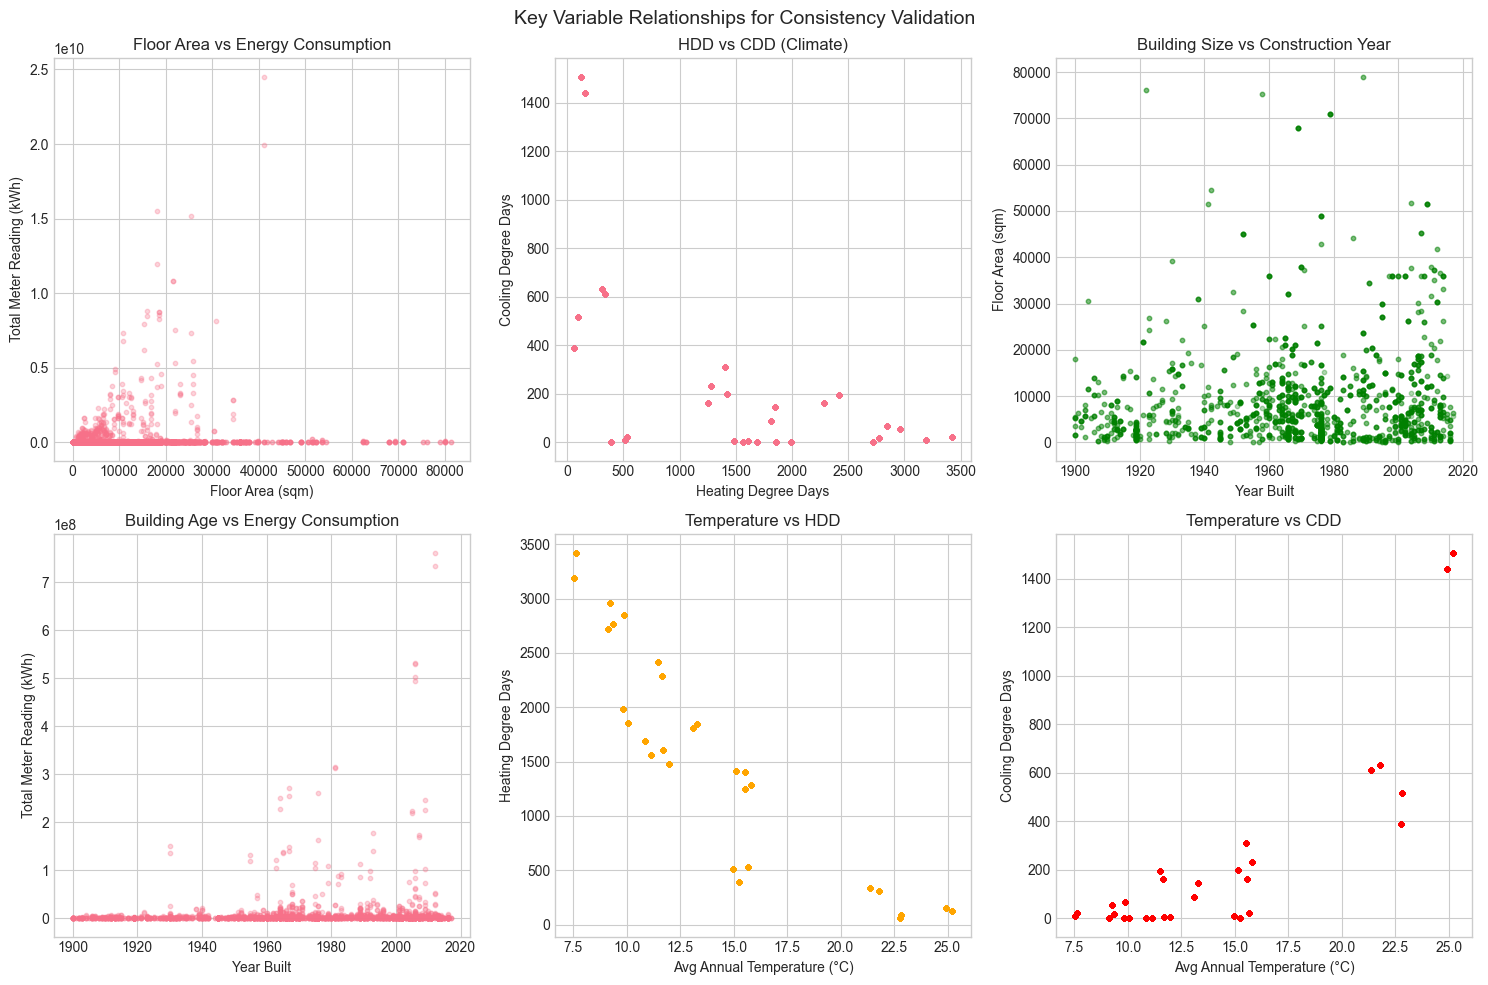

In [17]:
# Scatter plots for key relationships
def plot_key_relationships(df):
    """Visualize key variable relationships for consistency validation."""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot 1: sqm vs total_meter_reading (larger buildings use more energy)
    if 'sqm' in df.columns and 'total_meter_reading' in df.columns:
        data = df[['sqm', 'total_meter_reading']].dropna()
        axes[0, 0].scatter(data['sqm'], data['total_meter_reading'], alpha=0.3, s=10)
        axes[0, 0].set_xlabel('Floor Area (sqm)')
        axes[0, 0].set_ylabel('Total Meter Reading (kWh)')
        axes[0, 0].set_title('Floor Area vs Energy Consumption')
    
    # Plot 2: HDD vs CDD (climate relationship)
    if 'Total_HDD_Annual' in df.columns and 'Total_CDD_Annual' in df.columns:
        data = df[['Total_HDD_Annual', 'Total_CDD_Annual']].dropna()
        axes[0, 1].scatter(data['Total_HDD_Annual'], data['Total_CDD_Annual'], alpha=0.3, s=10)
        axes[0, 1].set_xlabel('Heating Degree Days')
        axes[0, 1].set_ylabel('Cooling Degree Days')
        axes[0, 1].set_title('HDD vs CDD (Climate)')
    
    # Plot 3: sqm vs yearbuilt (building size by construction era)
    if 'sqm' in df.columns and 'yearbuilt' in df.columns:
        data = df[['sqm', 'yearbuilt']].dropna()
        axes[0, 2].scatter(data['yearbuilt'], data['sqm'], alpha=0.3, s=10, color='green')
        axes[0, 2].set_xlabel('Year Built')
        axes[0, 2].set_ylabel('Floor Area (sqm)')
        axes[0, 2].set_title('Building Size vs Construction Year')
    
    # Plot 4: Year built vs total_meter_reading
    if 'yearbuilt' in df.columns and 'total_meter_reading' in df.columns:
        data = df[['yearbuilt', 'total_meter_reading']].dropna()
        axes[1, 0].scatter(data['yearbuilt'], data['total_meter_reading'], alpha=0.3, s=10)
        axes[1, 0].set_xlabel('Year Built')
        axes[1, 0].set_ylabel('Total Meter Reading (kWh)')
        axes[1, 0].set_title('Building Age vs Energy Consumption')
    
    # Plot 5: Temperature vs HDD
    if 'Avg_AirTemp_Annual' in df.columns and 'Total_HDD_Annual' in df.columns:
        data = df[['Avg_AirTemp_Annual', 'Total_HDD_Annual']].dropna()
        axes[1, 1].scatter(data['Avg_AirTemp_Annual'], data['Total_HDD_Annual'], alpha=0.3, s=10, color='orange')
        axes[1, 1].set_xlabel('Avg Annual Temperature (°C)')
        axes[1, 1].set_ylabel('Heating Degree Days')
        axes[1, 1].set_title('Temperature vs HDD')
    
    # Plot 6: Temperature vs CDD
    if 'Avg_AirTemp_Annual' in df.columns and 'Total_CDD_Annual' in df.columns:
        data = df[['Avg_AirTemp_Annual', 'Total_CDD_Annual']].dropna()
        axes[1, 2].scatter(data['Avg_AirTemp_Annual'], data['Total_CDD_Annual'], alpha=0.3, s=10, color='red')
        axes[1, 2].set_xlabel('Avg Annual Temperature (°C)')
        axes[1, 2].set_ylabel('Cooling Degree Days')
        axes[1, 2].set_title('Temperature vs CDD')
    
    plt.suptitle('Key Variable Relationships for Consistency Validation', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_key_relationships(df_complete)

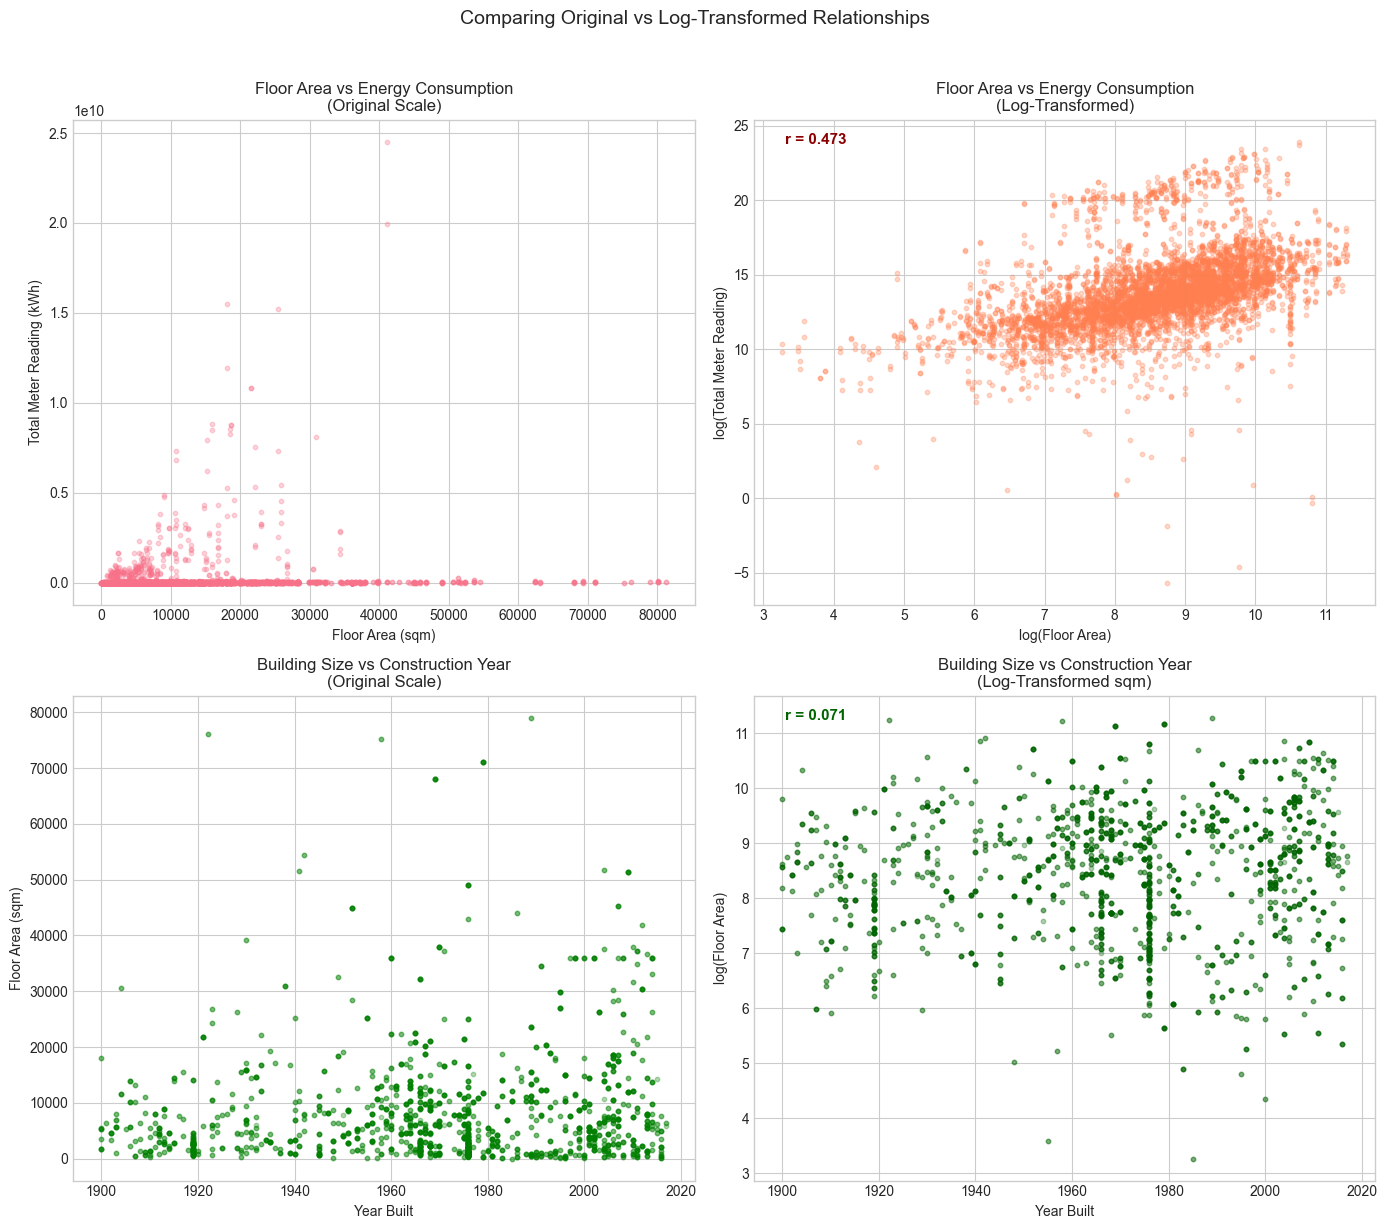


INTERPRETATION:
Log transformation reveals clearer patterns by reducing the
visual impact of extreme outliers:

• Floor Area vs Energy: The log-log plot shows a more
  interpretable positive relationship - larger buildings
  tend to consume more energy.

• Building Size vs Year Built: The log-transformed sqm
  shows whether construction eras favored different
  building sizes more clearly.


In [28]:
# Scatter plots with log-transformed variables for better visualization
def plot_log_transformed_relationships(df):
    """Visualize key variable relationships using log-transformed values."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Plot 1: log(sqm) vs log(total_meter_reading) - Original scale
    if 'sqm' in df.columns and 'total_meter_reading' in df.columns:
        data = df[['sqm', 'total_meter_reading']].dropna()
        axes[0, 0].scatter(data['sqm'], data['total_meter_reading'], alpha=0.3, s=10)
        axes[0, 0].set_xlabel('Floor Area (sqm)')
        axes[0, 0].set_ylabel('Total Meter Reading (kWh)')
        axes[0, 0].set_title('Floor Area vs Energy Consumption\n(Original Scale)')
    
    # Plot 2: log(sqm) vs log(total_meter_reading) - Log scale
    if 'sqm' in df.columns and 'total_meter_reading' in df.columns:
        data = df[['sqm', 'total_meter_reading']].dropna()
        # Filter out zeros for log transformation
        data = data[(data['sqm'] > 0) & (data['total_meter_reading'] > 0)]
        log_sqm = np.log(data['sqm'])
        log_meter = np.log(data['total_meter_reading'])
        
        axes[0, 1].scatter(log_sqm, log_meter, alpha=0.3, s=10, color='coral')
        axes[0, 1].set_xlabel('log(Floor Area)')
        axes[0, 1].set_ylabel('log(Total Meter Reading)')
        axes[0, 1].set_title('Floor Area vs Energy Consumption\n(Log-Transformed)')
        
        # Add correlation coefficient
        corr = log_sqm.corr(log_meter)
        axes[0, 1].annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                           fontsize=11, fontweight='bold', color='darkred')
    
    # Plot 3: sqm vs yearbuilt - Original scale
    if 'sqm' in df.columns and 'yearbuilt' in df.columns:
        data = df[['sqm', 'yearbuilt']].dropna()
        axes[1, 0].scatter(data['yearbuilt'], data['sqm'], alpha=0.3, s=10, color='green')
        axes[1, 0].set_xlabel('Year Built')
        axes[1, 0].set_ylabel('Floor Area (sqm)')
        axes[1, 0].set_title('Building Size vs Construction Year\n(Original Scale)')
    
    # Plot 4: log(sqm) vs yearbuilt - Log scale for sqm
    if 'sqm' in df.columns and 'yearbuilt' in df.columns:
        data = df[['sqm', 'yearbuilt']].dropna()
        data = data[data['sqm'] > 0]
        log_sqm = np.log(data['sqm'])
        
        axes[1, 1].scatter(data['yearbuilt'], log_sqm, alpha=0.3, s=10, color='darkgreen')
        axes[1, 1].set_xlabel('Year Built')
        axes[1, 1].set_ylabel('log(Floor Area)')
        axes[1, 1].set_title('Building Size vs Construction Year\n(Log-Transformed sqm)')
        
        # Add correlation coefficient
        corr = data['yearbuilt'].corr(log_sqm)
        axes[1, 1].annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                           fontsize=11, fontweight='bold', color='darkgreen')
    
    plt.suptitle('Comparing Original vs Log-Transformed Relationships', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("\nINTERPRETATION:")
    print("="*60)
    print("Log transformation reveals clearer patterns by reducing the")
    print("visual impact of extreme outliers:")
    print()
    print("• Floor Area vs Energy: The log-log plot shows a more")
    print("  interpretable positive relationship - larger buildings")
    print("  tend to consume more energy.")
    print()
    print("• Building Size vs Year Built: The log-transformed sqm")
    print("  shows whether construction eras favored different")
    print("  building sizes more clearly.")

plot_log_transformed_relationships(df_complete)

### Climate Variable Multicollinearity

The climate-related variables (`Avg_AirTemp_Annual`, `Total_HDD_Annual`, `Total_CDD_Annual`, `Count_Heating_Days_Annual`, `Count_Cooling_Days_Annual`) are expected to exhibit high intercorrelation because they measure related aspects of the same underlying climate conditions. Unlike regression analysis, where multicollinearity inflates standard errors and destabilises coefficient estimates, clustering algorithms do not estimate coefficients. However, multicollinearity in clustering presents a different concern: correlated variables effectively "double-count" the same underlying dimension, causing that dimension to receive disproportionate weight in distance calculations.

The following analysis quantifies the correlations among climate variables and assesses implications for clustering.

CLIMATE VARIABLE MULTICOLLINEARITY ANALYSIS

Climate variables analysed: 5
Complete cases: 5,902 of 5,902 records

📊 CORRELATION MATRIX (Climate Variables)
--------------------------------------------------


,Avg_AirTemp_Annual,Total_HDD_Annual,Total_CDD_Annual,Count_Heating_Days_Annual,Count_Cooling_Days_Annual
Avg_AirTemp_Annual,1.00,-0.94,0.84,-0.95,0.95
Total_HDD_Annual,-0.94,1.00,-0.68,0.85,-0.80
Total_CDD_Annual,0.84,-0.68,1.00,-0.74,0.85
Count_Heating_Days_Annual,-0.95,0.85,-0.74,1.00,-0.94
Count_Cooling_Days_Annual,0.95,-0.80,0.85,-0.94,1.00



⚠️  HIGHLY CORRELATED PAIRS (|r| > 0.7)
--------------------------------------------------
  • Avg_AirTemp_Annual ↔ Total_HDD_Annual: r = -0.936
  • Avg_AirTemp_Annual ↔ Total_CDD_Annual: r = 0.845
  • Avg_AirTemp_Annual ↔ Count_Heating_Days_Annual: r = -0.954
  • Avg_AirTemp_Annual ↔ Count_Cooling_Days_Annual: r = 0.952
  • Total_HDD_Annual ↔ Count_Heating_Days_Annual: r = 0.855
  • Total_HDD_Annual ↔ Count_Cooling_Days_Annual: r = -0.797
  • Total_CDD_Annual ↔ Count_Heating_Days_Annual: r = -0.744
  • Total_CDD_Annual ↔ Count_Cooling_Days_Annual: r = 0.853
  • Count_Heating_Days_Annual ↔ Count_Cooling_Days_Annual: r = -0.940


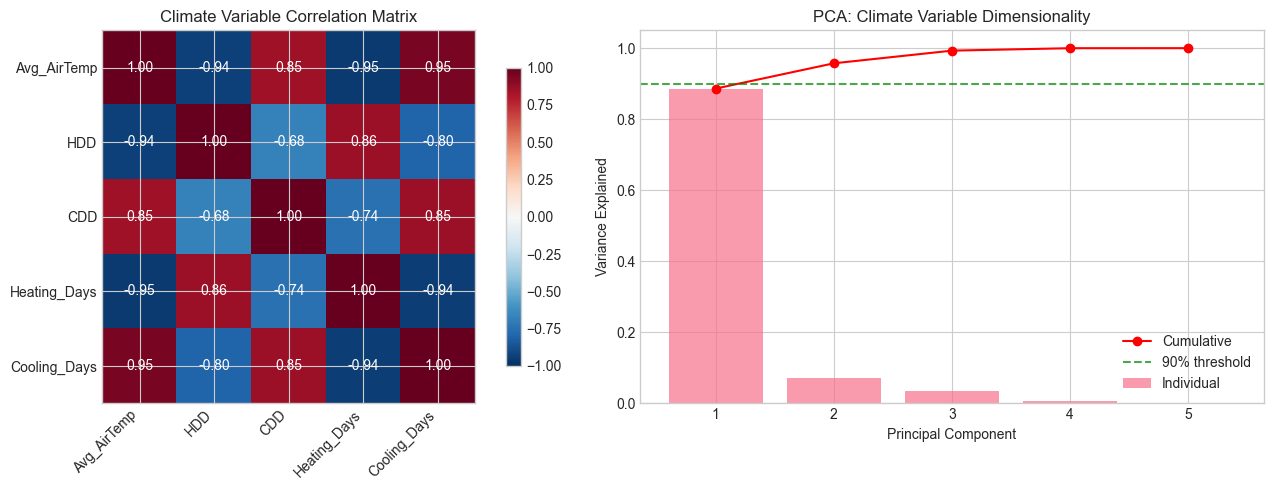


📋 IMPLICATIONS FOR CLUSTERING
--------------------------------------------------
  • 2 principal component(s) explain ≥90% of climate variance
  • First component explains 88.6% of variance

  ⚠️  High multicollinearity detected among climate variables.
  Including all 5 climate variables may over-weight climate
  relative to other features (e.g., building size, type).

📖 INTERPRETATION OF CORRELATIONS
--------------------------------------------------
  These correlations are physically expected:
  • Avg_AirTemp ↔ HDD (negative): Warmer locations need less heating
  • Avg_AirTemp ↔ CDD (positive): Warmer locations need more cooling
  • HDD ↔ CDD (negative): Cold climates have low cooling demand
  • HDD ↔ Heating_Days (positive): More degree days = more heating days
  • CDD ↔ Cooling_Days (positive): More degree days = more cooling days
  All five variables measure the same underlying concept: climate severity.

  RECOMMENDATIONS:
  Option 1: Use PCA to reduce climate variables to 1-2

In [47]:
# Climate Variable Correlation Analysis
def analyze_climate_multicollinearity(df):
    """Analyze correlations among climate variables and their implications for clustering."""
    
    climate_vars = ['Avg_AirTemp_Annual', 'Total_HDD_Annual', 'Total_CDD_Annual', 
                    'Count_Heating_Days_Annual', 'Count_Cooling_Days_Annual']
    
    # Filter to available climate variables
    available_climate = [col for col in climate_vars if col in df.columns]
    
    if len(available_climate) < 2:
        print("Insufficient climate variables for correlation analysis.")
        return None
    
    # Calculate correlation matrix for climate variables
    climate_data = df[available_climate].dropna()
    climate_corr = climate_data.corr()
    
    print("=" * 70)
    print("CLIMATE VARIABLE MULTICOLLINEARITY ANALYSIS")
    print("=" * 70)
    
    print(f"\nClimate variables analysed: {len(available_climate)}")
    print(f"Complete cases: {len(climate_data):,} of {len(df):,} records")
    
    # Display correlation matrix
    print("\n📊 CORRELATION MATRIX (Climate Variables)")
    print("-" * 50)
    display(climate_corr.round(3))
    
    # Identify highly correlated pairs (|r| > 0.7)
    print("\n⚠️  HIGHLY CORRELATED PAIRS (|r| > 0.7)")
    print("-" * 50)
    high_corr_pairs = []
    for i in range(len(available_climate)):
        for j in range(i+1, len(available_climate)):
            corr_val = climate_corr.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((available_climate[i], available_climate[j], corr_val))
                print(f"  • {available_climate[i]} ↔ {available_climate[j]}: r = {corr_val:.3f}")
    
    if not high_corr_pairs:
        print("  No pairs with |r| > 0.7 found.")
    
    # Visualize correlation matrix
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Heatmap
    im = axes[0].imshow(climate_corr, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[0].set_xticks(range(len(available_climate)))
    axes[0].set_yticks(range(len(available_climate)))
    
    # Shorter labels for readability
    short_labels = [col.replace('_Annual', '').replace('Count_', '').replace('Total_', '') 
                    for col in available_climate]
    axes[0].set_xticklabels(short_labels, rotation=45, ha='right')
    axes[0].set_yticklabels(short_labels)
    
    # Add correlation values to heatmap
    for i in range(len(available_climate)):
        for j in range(len(available_climate)):
            text_color = 'white' if abs(climate_corr.iloc[i, j]) > 0.5 else 'black'
            axes[0].text(j, i, f'{climate_corr.iloc[i, j]:.2f}', ha='center', va='center', color=text_color)
    
    axes[0].set_title('Climate Variable Correlation Matrix')
    plt.colorbar(im, ax=axes[0], shrink=0.8)
    
    # Eigenvalue analysis (variance explained)
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    scaler = StandardScaler()
    climate_scaled = scaler.fit_transform(climate_data)
    
    pca = PCA()
    pca.fit(climate_scaled)
    
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    
    axes[1].bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, label='Individual')
    axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'ro-', label='Cumulative')
    axes[1].axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% threshold')
    axes[1].set_xlabel('Principal Component')
    axes[1].set_ylabel('Variance Explained')
    axes[1].set_title('PCA: Climate Variable Dimensionality')
    axes[1].set_xticks(range(1, len(explained_var)+1))
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Summary and recommendations
    print("\n📋 IMPLICATIONS FOR CLUSTERING")
    print("-" * 50)
    
    n_components_90 = np.argmax(cumulative_var >= 0.9) + 1
    print(f"  • {n_components_90} principal component(s) explain ≥90% of climate variance")
    print(f"  • First component explains {explained_var[0]*100:.1f}% of variance")
    
    if len(high_corr_pairs) >= 3:
        print("\n  ⚠️  High multicollinearity detected among climate variables.")
        print("  Including all 5 climate variables may over-weight climate")
        print("  relative to other features (e.g., building size, type).")
    
    # Physical interpretation of correlations
    print("\n📖 INTERPRETATION OF CORRELATIONS")
    print("-" * 50)
    print("  These correlations are physically expected:")
    print("  • Avg_AirTemp ↔ HDD (negative): Warmer locations need less heating")
    print("  • Avg_AirTemp ↔ CDD (positive): Warmer locations need more cooling")
    print("  • HDD ↔ CDD (negative): Cold climates have low cooling demand")
    print("  • HDD ↔ Heating_Days (positive): More degree days = more heating days")
    print("  • CDD ↔ Cooling_Days (positive): More degree days = more cooling days")
    print("  All five variables measure the same underlying concept: climate severity.")

    print("\n  RECOMMENDATIONS:")
    print("  Option 1: Use PCA to reduce climate variables to 1-2 components")
    print("  Option 2: Select representative variables (e.g., Avg_AirTemp_Annual + Total_HDD_Annual)")
    print("  Option 3: Proceed with all variables but document the implicit climate weighting")
    print("=" * 70)
    
    return climate_corr

climate_correlation = analyze_climate_multicollinearity(df_complete)

---

## 5. Representativeness Evaluation

Representativeness analysis examines whether a dataset adequately captures the diversity of the broader population it is intended to represent. For building energy data, this involves assessing coverage across geographic locations, building types, energy meter categories, and temporal periods. Imbalances in representation can affect the generalisability of clustering results—for example, if certain building types or climate zones are underrepresented, the resulting energy consumption patterns may not apply universally.

This section evaluates the distribution of categorical variables including country, region, primary space usage, and meter type to identify any systematic gaps or over-representation. The analysis considers both the breadth of categories covered and the balance of records across categories.

In [29]:
# Analyze distribution of categorical variables
def analyze_categorical_distribution(df):
    """Analyze distribution of categorical variables for representativeness."""
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    print("CATEGORICAL VARIABLE DISTRIBUTIONS")
    print("="*60)
    
    for col in categorical_cols:
        print(f"\n{col.upper()}:")
        value_counts = df[col].value_counts()
        value_pcts = df[col].value_counts(normalize=True) * 100
        
        summary_df = pd.DataFrame({
            'Count': value_counts,
            'Percentage': value_pcts.round(2)
        })
        display(summary_df)
        
        # Check for potential underrepresentation
        if len(value_counts) > 1:
            min_pct = value_pcts.min()
            if min_pct < 5:
                print(f"  ⚠ NOTE: Some categories have <5% representation")

analyze_categorical_distribution(df_complete)

CATEGORICAL VARIABLE DISTRIBUTIONS

BUILDING_ID:


,Count,Percentage
building_id,,
Bobcat_education_Alissa,10,0.17
Bobcat_education_Dylan,10,0.17
Bobcat_assembly_Camilla,8,0.14
Eagle_education_Brooke,8,0.14
Eagle_lodging_Blake,8,0.14
...,...,...
Lamb_education_Renae,1,0.02
Lamb_office_Joanna,1,0.02
Rat_education_Angelica,1,0.02


  ⚠ NOTE: Some categories have <5% representation

METER:


,Count,Percentage
meter,,
electricity,3079,52.17
chilledwater,1069,18.11
steam,688,11.66
hotwater,351,5.95
gas,347,5.88
water,287,4.86
irrigation,73,1.24
solar,8,0.14


  ⚠ NOTE: Some categories have <5% representation

SITE_ID:


,Count,Percentage
site_id,,
Hog,661,11.20
Bull,616,10.44
Fox,608,10.30
Panther,597,10.12
Rat,590,10.00
Eagle,590,10.00
Lamb,524,8.88
Cockatoo,515,8.73
Bobcat,213,3.61


  ⚠ NOTE: Some categories have <5% representation

PRIMARYSPACEUSAGE:


,Count,Percentage
primaryspaceusage,,
Education,2394,40.94
Office,1203,20.57
Lodging/residential,679,11.61
Entertainment/public assembly,660,11.29
Public services,417,7.13
Healthcare,109,1.86
Other,98,1.68
Parking,74,1.27
Retail,44,0.75


  ⚠ NOTE: Some categories have <5% representation

REGION:


,Count,Percentage
region,,
"Minneapolis, Minnesota",661,13.50
"Austin, Texas",616,12.58
"Tempe, Arizona",608,12.42
"Orlando, Florida",597,12.19
"Washington, District of Columbia",590,12.05
"Cardiff, Cymru / Wales",524,10.70
"Town of Ithaca, New York",515,10.52
"Berkeley, California",184,3.76
"Princeton, New Jersey",184,3.76


  ⚠ NOTE: Some categories have <5% representation

COUNTRY:


,Count,Percentage
country,,
United States of America,3955,80.76
United Kingdom,695,14.19
Netherlands,132,2.70
Canada,115,2.35


  ⚠ NOTE: Some categories have <5% representation


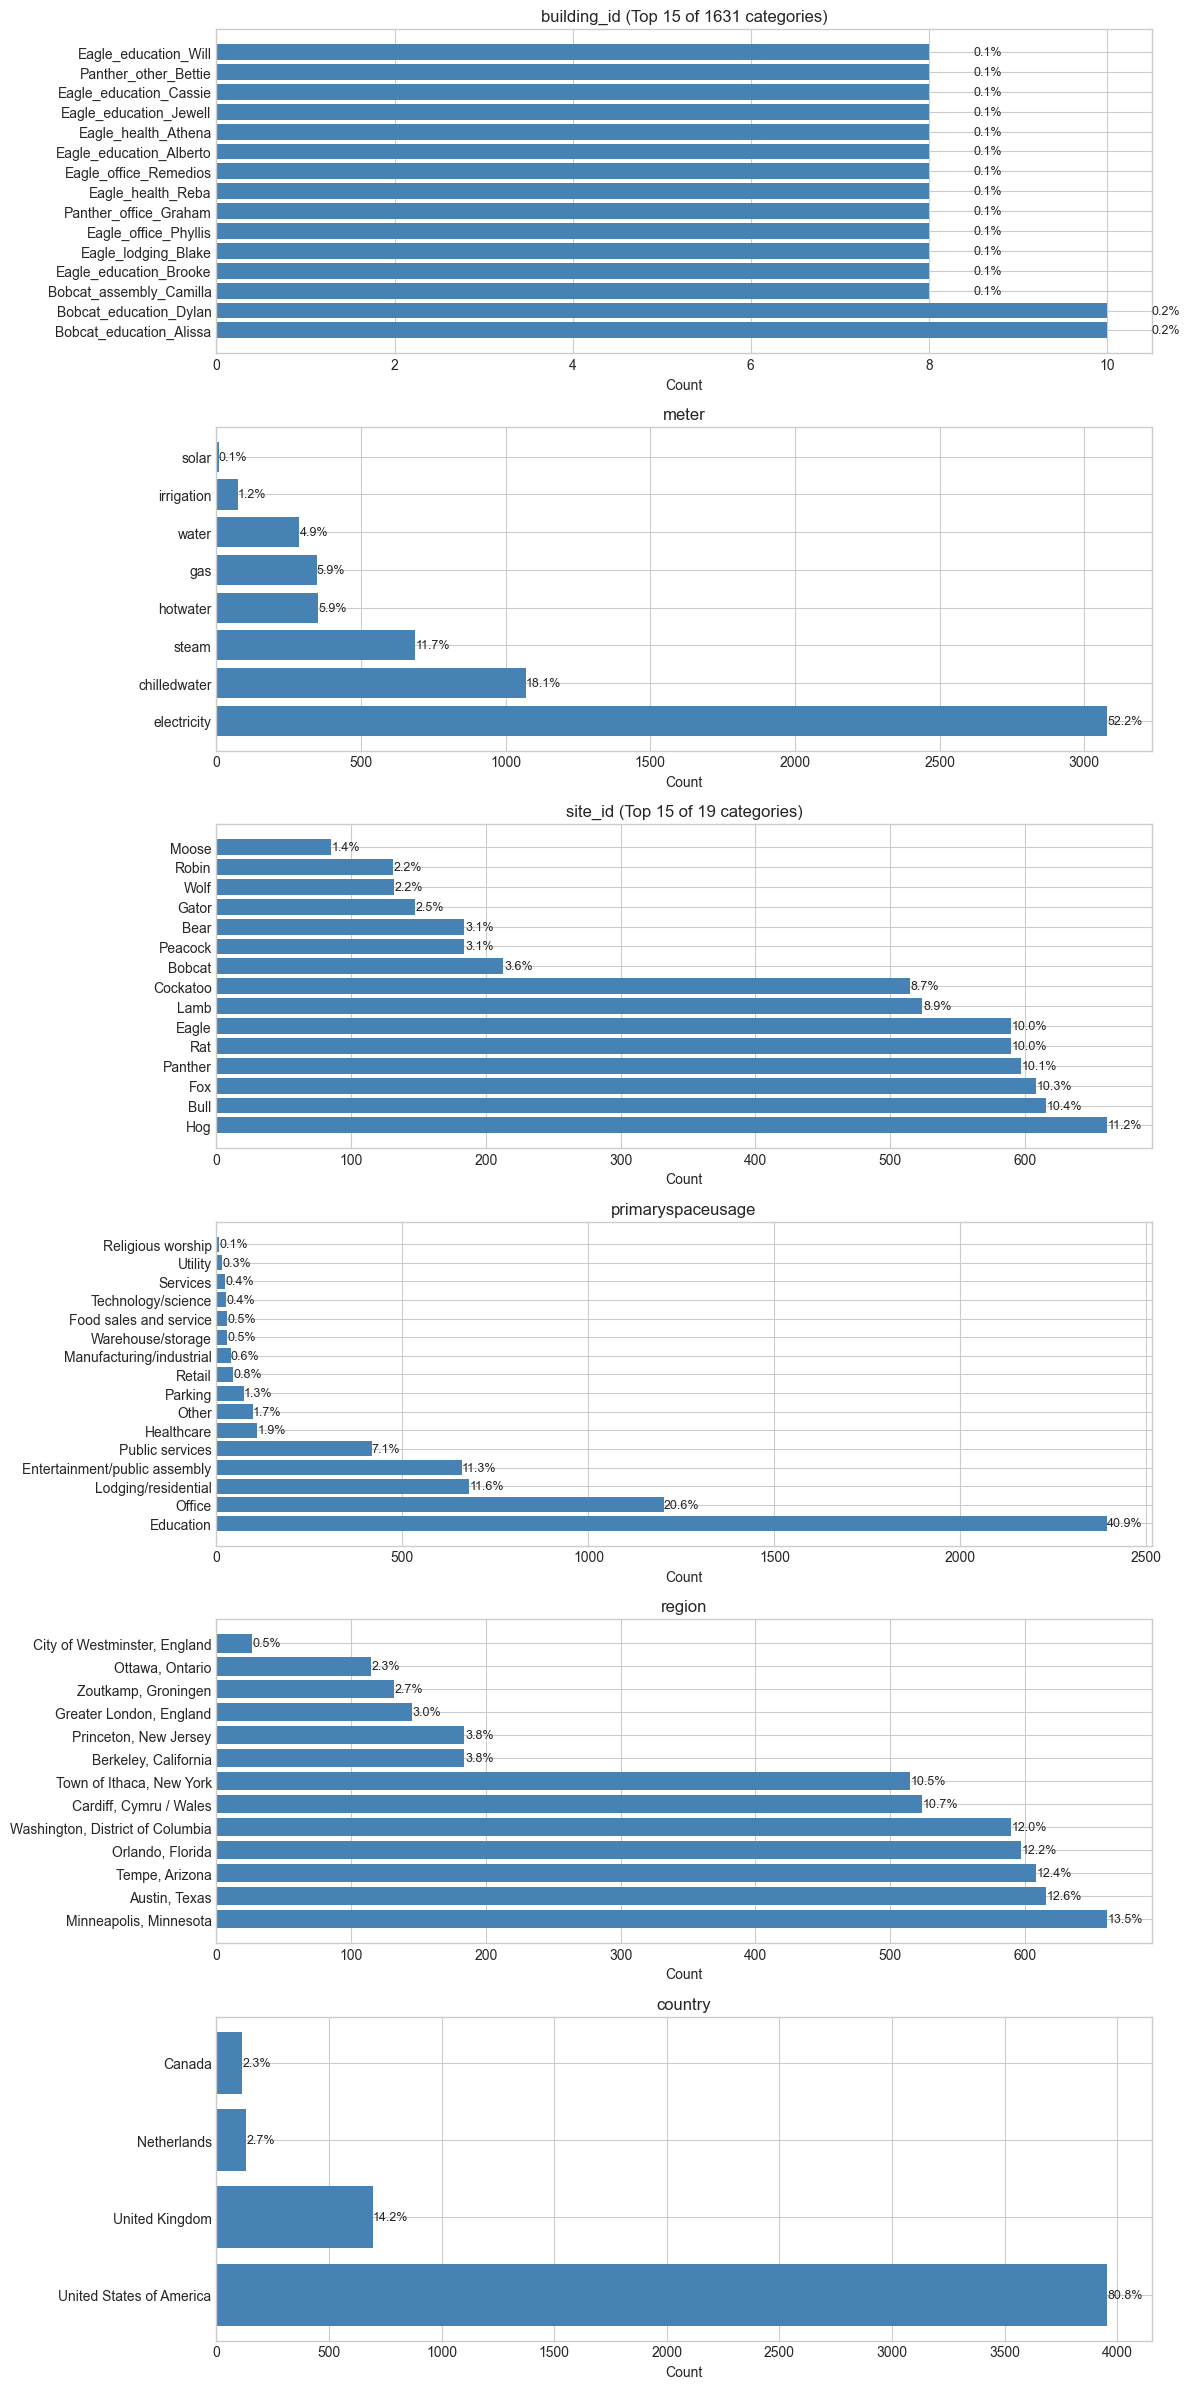

In [31]:
# Visualize categorical distributions
def visualize_categorical_distributions(df):
    """Create bar charts for categorical variable distributions."""
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    n_cols = len(categorical_cols)
    
    if n_cols == 0:
        print("No categorical columns found")
        return
    
    fig, axes = plt.subplots(n_cols, 1, figsize=(12, 4*n_cols))
    if n_cols == 1:
        axes = [axes]
    
    for i, col in enumerate(categorical_cols):
        value_counts = df[col].value_counts()
        
        # Limit to top 15 categories if too many
        if len(value_counts) > 16:
            value_counts = value_counts.head(15)
            axes[i].set_title(f'{col} (Top 15 of {df[col].nunique()} categories)')
        else:
            axes[i].set_title(f'{col}')
        
        bars = axes[i].barh(value_counts.index, value_counts.values, color='steelblue')
        axes[i].set_xlabel('Count')
        
        # Add percentage labels
        total = df[col].notna().sum()
        for bar, count in zip(bars, value_counts.values):
            pct = count / total * 100
            axes[i].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                        f'{pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

visualize_categorical_distributions(df_complete)

In [30]:
# Subgroup quality analysis
def subgroup_quality_analysis(df, group_col):
    """Analyze data quality metrics by subgroup to detect quality disparities."""
    
    if group_col not in df.columns:
        print(f"Column {group_col} not found")
        return None
    
    print(f"\nSUBGROUP QUALITY ANALYSIS BY: {group_col.upper()}")
    print("="*60)
    
    subgroup_stats = []
    
    for group in df[group_col].dropna().unique():
        group_data = df[df[group_col] == group]
        numerical_cols = group_data.select_dtypes(include=[np.number]).columns
        
        stats = {
            'Subgroup': group,
            'Sample Size': len(group_data),
            'Sample %': len(group_data) / len(df) * 100,
            'Complete Cases %': group_data.dropna().shape[0] / len(group_data) * 100 if len(group_data) > 0 else 0,
            'Missing yearbuilt %': group_data['yearbuilt'].isna().mean() * 100 if 'yearbuilt' in group_data.columns else 0
        }
        
        # Add mean total_meter_reading if available
        if 'total_meter_reading' in numerical_cols:
            stats['Mean Meter Reading'] = group_data['total_meter_reading'].mean()
        
        subgroup_stats.append(stats)
    
    subgroup_df = pd.DataFrame(subgroup_stats)
    subgroup_df = subgroup_df.sort_values('Sample Size', ascending=False)
    
    display(subgroup_df.round(2))
    
    # Flag potential quality disparities
    if 'Complete Cases %' in subgroup_df.columns:
        min_complete = subgroup_df['Complete Cases %'].min()
        max_complete = subgroup_df['Complete Cases %'].max()
        if max_complete - min_complete > 20:
            print(f"\n⚠ NOTE: Quality disparity detected: Complete cases range from {min_complete:.1f}% to {max_complete:.1f}%")
    
    return subgroup_df

# Analyze by building type
subgroup_by_type = subgroup_quality_analysis(df_complete, 'primaryspaceusage')


SUBGROUP QUALITY ANALYSIS BY: PRIMARYSPACEUSAGE


,Subgroup,Sample Size,Sample %,Complete Cases %,Missing yearbuilt %,Mean Meter Reading
1,Education,2394,40.56,54.59,45.41,118275962.34
7,Office,1203,20.38,31.34,68.66,103618537.26
2,Lodging/residential,679,11.50,59.35,40.65,21719456.88
0,Entertainment/public assembly,660,11.18,43.64,56.36,59020989.72
4,Public services,417,7.07,30.70,69.30,117238103.05
11,Healthcare,109,1.85,28.44,71.56,482254028.42
8,Other,98,1.66,44.90,55.10,1693711.69
3,Parking,74,1.25,67.57,32.43,588151.39
15,Retail,44,0.75,68.18,31.82,2626419.23
12,Manufacturing/industrial,38,0.64,57.89,42.11,1291993.74



⚠ NOTE: Quality disparity detected: Complete cases range from 0.0% to 68.2%


In [21]:
# Analyze by region
subgroup_by_region = subgroup_quality_analysis(df_complete, 'region')


SUBGROUP QUALITY ANALYSIS BY: REGION


,Subgroup,Sample Size,Sample %,Complete Cases %,Missing yearbuilt %,Mean Meter Reading
5,"Minneapolis, Minnesota",661,11.20,0.00,100.00,20194186.39
1,"Austin, Texas",616,10.44,0.00,100.00,5187399.33
4,"Tempe, Arizona",608,10.30,76.97,23.03,21058751.53
8,"Orlando, Florida",597,10.12,100.00,0.00,3897484.63
10,"Washington, District of Columbia",590,10.00,48.47,51.53,973341.96
6,"Cardiff, Cymru / Wales",524,8.88,99.24,0.76,204851.63
2,"Town of Ithaca, New York",515,8.73,91.07,8.93,1930201.66
0,"Berkeley, California",184,3.12,97.83,2.17,1509940.09
9,"Princeton, New Jersey",184,3.12,0.00,100.00,8385323.35
7,"Greater London, England",145,2.46,76.55,23.45,1337313.68



⚠ Quality disparity detected: Complete cases range from 0.0% to 100.0%


In [32]:
# # Temporal coverage analysis
# def analyze_temporal_coverage(df):
#     """Analyze temporal distribution of data for representativeness."""
    
#     print("\nTEMPORAL COVERAGE ANALYSIS")
#     print("="*60)
    
#     if 'year' in df.columns:
#         print("\nData Year Distribution:")
#         year_counts = df['year'].value_counts().sort_index()
#         display(year_counts.to_frame('Count'))
        
#         # Visualize
#         plt.figure(figsize=(10, 4))
#         year_counts.plot(kind='bar', color='steelblue', edgecolor='white')
#         plt.title('Data Distribution by Year')
#         plt.xlabel('Year')
#         plt.ylabel('Count')
#         plt.xticks(rotation=0)
#         plt.tight_layout()
#         plt.show()
    
#     if 'yearbuilt' in df.columns:
#         print("\nBuilding Age Distribution (Year Built):")
#         yearbuilt_data = df['yearbuilt'].dropna()
        
#         # Create decade bins
#         decades = (yearbuilt_data // 10 * 10).value_counts().sort_index()
        
#         plt.figure(figsize=(12, 4))
#         decades.plot(kind='bar', color='coral', edgecolor='white')
#         plt.title('Buildings by Decade Built')
#         plt.xlabel('Decade')
#         plt.ylabel('Count')
#         plt.xticks(rotation=45)
#         plt.tight_layout()
#         plt.show()
        
#         print(f"\n  Oldest building: {yearbuilt_data.min():.0f}")
#         print(f"  Newest building: {yearbuilt_data.max():.0f}")
#         print(f"  Median year built: {yearbuilt_data.median():.0f}")

# analyze_temporal_coverage(df_complete)


GEOGRAPHIC COVERAGE ANALYSIS

Country Distribution:


,Count
country,
United States of America,3955
United Kingdom,695
Netherlands,132
Canada,115


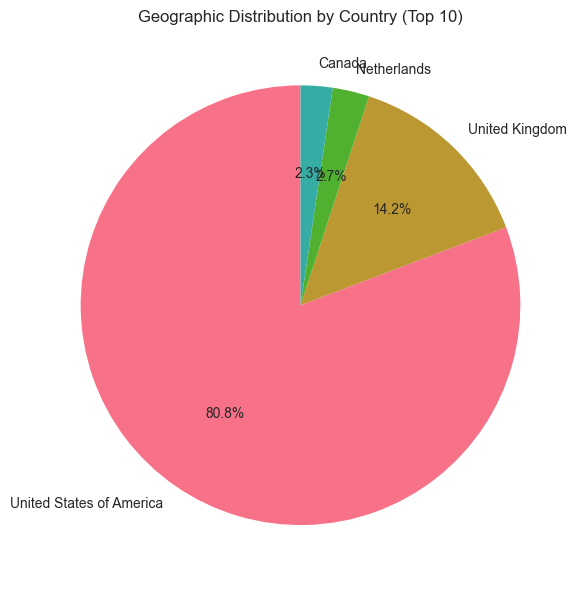


Number of unique sites: 19
Records per site - Min: 14, Max: 661, Median: 184


In [23]:
# Geographic coverage visualization
def analyze_geographic_coverage(df):
    """Analyze geographic distribution for representativeness."""
    
    print("\nGEOGRAPHIC COVERAGE ANALYSIS")
    print("="*60)
    
    if 'country' in df.columns:
        print("\nCountry Distribution:")
        country_counts = df['country'].value_counts()
        display(country_counts.to_frame('Count'))
        
        # Pie chart for country distribution
        plt.figure(figsize=(10, 6))
        country_counts.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90)
        plt.title('Geographic Distribution by Country (Top 10)')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
    
    if 'site_id' in df.columns:
        print(f"\nNumber of unique sites: {df['site_id'].nunique()}")
        site_counts = df['site_id'].value_counts()
        print(f"Records per site - Min: {site_counts.min()}, Max: {site_counts.max()}, Median: {site_counts.median():.0f}")

analyze_geographic_coverage(df_complete)

### ⚠️ Important Note: Small Subgroups and Clustering Implications

The representativeness analysis reveals significant imbalances in the dataset that have important implications for clustering:

#### Observed Imbalances

| Dimension | Dominant Categories | Underrepresented Categories |
|-----------|--------------------|-----------------------------|
| **Country** | USA (80.8%) | Netherlands (2.7%), Canada (2.3%) |
| **Building Type** | Education (40.9%), Office (20.6%) | Religious (0.14%), Retail (0.75%), Manufacturing (0.65%) |
| **Meter Type** | Electricity (52.2%) | Solar (0.14%), Irrigation (1.2%) |

#### How This Affects Clustering

1. **Cluster formation**: Clustering algorithms optimise for the majority. Small subgroups (e.g., religious buildings, solar meters) are unlikely to form distinct clusters and will typically be absorbed into larger clusters or scattered across multiple clusters.

2. **Statistical instability**: Clusters containing few observations from rare categories are less reliable—small data changes can dramatically alter their membership.

3. **Interpretation bias**: Resulting clusters will primarily reflect patterns in US educational and office buildings with electricity meters. Findings may not generalise to other building types, countries, or energy sources.

#### Handling Strategies

For this analysis, the following approach is recommended:

1. **Proceed with all data** — Do not exclude rare categories, as they represent legitimate buildings in the dataset.

2. **Document limitations** — Clearly state that clustering results primarily reflect:
   - United States buildings (80.8% of data)
   - Education and office buildings (61.5% combined)
   - Electricity consumption patterns (52.2% of readings)

3. **Consider aggregating rare meter types** for categorical features:
   - Keep as-is: electricity, chilledwater, steam, gas, hotwater
   - Combine into "Other": water, irrigation, solar

4. **Post-clustering validation** — After clustering, examine cluster composition to assess whether rare categories:
   - Cluster together (suggesting distinct patterns)
   - Scatter randomly (suggesting they behave as noise)
   - Concentrate in specific clusters (suggesting absorption into majority patterns)

5. **Avoid over-interpreting** clusters that contain very few buildings from rare categories.

#### Quality Disparity Note

The subgroup analysis also revealed that data completeness varies significantly across building types (complete cases ranging from 0% to 68.2%). This means some subgroups have more missing `yearbuilt` data than others, which could introduce systematic bias if `yearbuilt` is used as a clustering feature. It will be important to impute `yearbuilt`.

#### Coverage Gaps and Project Goals

The project objective is to segment commercial buildings by structural characteristics, usage type, and climatic context to identify efficiency outliers and prioritise retrofit interventions. The identified coverage gaps have the following implications for these goals:

**Gaps that matter for project goals:**

| Gap | Impact on Project Goals | 
|-----|------------------------|
| Geographic concentration (80.8% USA) | Peer groups and benchmarks will reflect US building stock and climate conditions. Findings cannot be directly applied to buildings in other countries without validation. |
| Building type imbalance | Clusters will be optimised for education and office buildings. Retail, manufacturing, and religious buildings may not receive meaningful peer groups for benchmarking. | 
| Missing `yearbuilt` (47%) | Building age is relevant for retrofit prioritisation. The gap introduces uncertainty in age-related clustering and efficiency assessments. |
| Dataset age (~10 years) | The data originates from 2016–2017. Building energy patterns may have shifted due to changes in equipment efficiency, building codes, occupancy patterns (e.g., post-pandemic hybrid work), and climate conditions. Findings reflect historical rather than current performance. | 

**Gaps with limited impact:**

| Gap | Reason for Limited Impact |
|-----|---------------------------|
| Meter type concentration | The project focuses on overall building energy performance. Electricity dominance is consistent with typical commercial building profiles. |
| Climate variable multicollinearity | Can be addressed through preprocessing (PCA or feature selection) without data collection. |

**Assessment:** The dataset is adequate for identifying energy efficiency patterns and peer groups among US educational and office buildings. For the stated project goal of prioritising retrofit interventions, this scope remains valuable because:
1. US commercial buildings represent a significant share of global building energy consumption
2. Education and office buildings are priority sectors for decarbonisation policy
3. The methodology can be extended to other building types and regions when additional data becomes available

**Project scope statement:** 

>  This analysis identifies energy consumption peer groups for US educational and office buildings, enabling fair benchmarking and retrofit prioritisation within this population. Generalisations to other countries or building types require additional data collection and validation.

---

## 6. Comprehensive Data Quality Summary

Aggregate all quality assessments into a comprehensive report that can be used to update the `DATA_QUALITY_REPORT.md` documentation.

In [24]:
def generate_quality_summary(df, dataset_name="Dataset"):
    """Generate a comprehensive data quality summary."""
    
    print("="*70)
    print(f"DATA QUALITY SUMMARY REPORT: {dataset_name}")
    print("="*70)
    print(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
    print("="*70)
    
    # 1. Dataset Overview
    print("\n📊 DATASET OVERVIEW")
    print("-"*40)
    print(f"  Total Records: {len(df):,}")
    print(f"  Total Features: {len(df.columns)}")
    print(f"  Numerical Features: {len(df.select_dtypes(include=[np.number]).columns)}")
    print(f"  Categorical Features: {len(df.select_dtypes(include=['object']).columns)}")
    
    # 2. Completeness Summary
    print("\n📋 COMPLETENESS SUMMARY")
    print("-"*40)
    complete_cases = df.dropna().shape[0]
    complete_pct = complete_cases / len(df) * 100
    print(f"  Complete Cases: {complete_cases:,} ({complete_pct:.1f}%)")
    
    missing_features = df.isnull().sum()
    features_with_missing = (missing_features > 0).sum()
    print(f"  Features with Missing Data: {features_with_missing} of {len(df.columns)}")
    
    if features_with_missing > 0:
        print("\n  Missing Data by Feature (>0%):")
        for col in missing_features[missing_features > 0].sort_values(ascending=False).index:
            pct = missing_features[col] / len(df) * 100
            severity = "Critical" if pct > 50 else "High" if pct > 20 else "Moderate" if pct > 5 else "Low"
            print(f"    - {col}: {missing_features[col]:,} ({pct:.1f}%) [{severity}]")
    
    # 3. Accuracy Summary
    print("\n🎯 ACCURACY SUMMARY (Outliers by IQR)")
    print("-"*40)
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    total_outliers = 0
    
    for col in numerical_cols:
        data = df[col].dropna()
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        total_outliers += outliers
        pct = outliers / len(data) * 100
        if pct > 5:
            print(f"    - {col}: {outliers:,} outliers ({pct:.1f}%)")
    
    print(f"\n  Total Potential Outliers: {total_outliers:,}")
    
    # 4. Consistency Summary
    print("\n🔗 CONSISTENCY SUMMARY")
    print("-"*40)
    
    if 'yearbuilt' in df.columns and 'year' in df.columns:
        violations = (df['yearbuilt'] > df['year']).sum()
        status = "✓ Consistent" if violations == 0 else f"⚠ {violations} violations"
        print(f"  Year built ≤ measurement year: {status}")
    
    if 'Total_HDD_Annual' in df.columns and 'Total_CDD_Annual' in df.columns:
        corr = df['Total_HDD_Annual'].corr(df['Total_CDD_Annual'])
        status = "✓ Expected" if corr < 0 else "△ Check data"
        print(f"  HDD-CDD correlation: {corr:.3f} ({status})")
    
    # 5. Representativeness Summary
    print("\n🌍 REPRESENTATIVENESS SUMMARY")
    print("-"*40)
    
    if 'primaryspaceusage' in df.columns:
        n_types = df['primaryspaceusage'].nunique()
        print(f"  Building Types Represented: {n_types}")
    
    if 'country' in df.columns:
        n_countries = df['country'].nunique()
        print(f"  Countries Represented: {n_countries}")
    
    if 'region' in df.columns:
        n_regions = df['region'].dropna().nunique()
        print(f"  Regions Represented: {n_regions}")
    
    if 'year' in df.columns:
        years = df['year'].dropna().unique()
        print(f"  Data Years: {sorted(years)}")
    
    if 'building_id' in df.columns:
        print(f"  Unique Buildings: {df['building_id'].nunique()}")
    
    print("\n" + "="*70)
    print("END OF QUALITY SUMMARY REPORT")
    print("="*70)

# Generate the comprehensive summary
generate_quality_summary(df_complete, "Building Energy Complete Dataset")

DATA QUALITY SUMMARY REPORT: Building Energy Complete Dataset
Generated: 2026-01-06 12:41

📊 DATASET OVERVIEW
----------------------------------------
  Total Records: 5,902
  Total Features: 15
  Numerical Features: 9
  Categorical Features: 6

📋 COMPLETENESS SUMMARY
----------------------------------------
  Complete Cases: 2,726 (46.2%)
  Features with Missing Data: 4 of 15

  Missing Data by Feature (>0%):
    - yearbuilt: 3,121 (52.9%) [Critical]
    - region: 1,005 (17.0%) [Moderate]
    - country: 1,005 (17.0%) [Moderate]
    - primaryspaceusage: 55 (0.9%) [Low]

🎯 ACCURACY SUMMARY (Outliers by IQR)
----------------------------------------
    - total_meter_reading: 862 outliers (14.6%)
    - sqm: 339 outliers (5.7%)
    - Total_CDD_Annual: 608 outliers (10.3%)

  Total Potential Outliers: 1,809

🔗 CONSISTENCY SUMMARY
----------------------------------------
  Year built ≤ measurement year: ⚠ 1 violations
  HDD-CDD correlation: -0.678 (✓ Expected)

🌍 REPRESENTATIVENESS SUMMARY
-

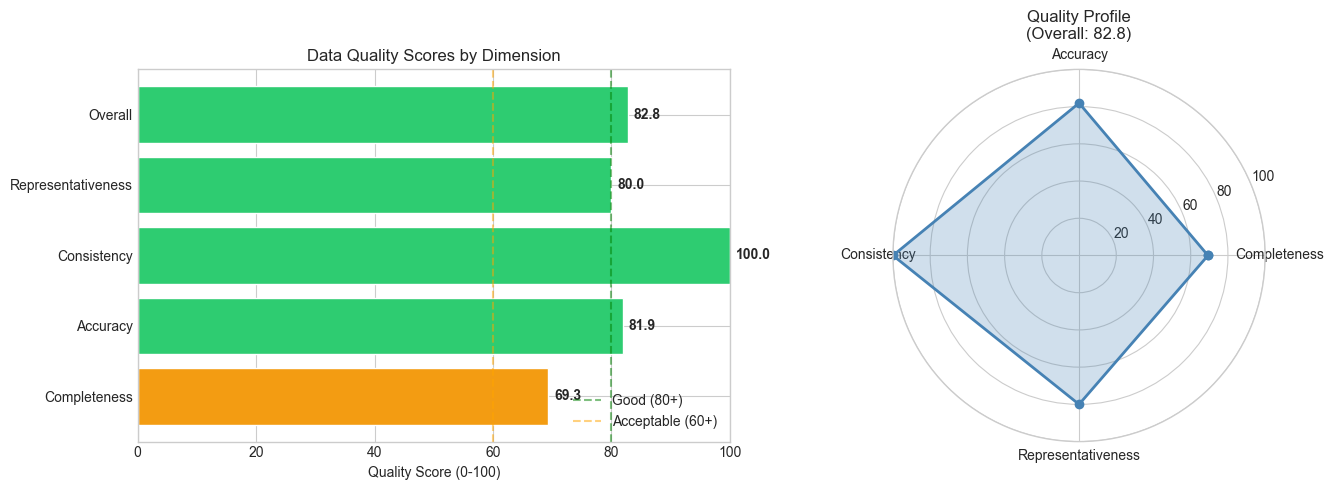

In [25]:
# Create quality score dashboard
def create_quality_dashboard(df):
    """Create a visual quality score dashboard."""
    
    # Calculate quality scores (0-100)
    scores = {}
    
    # Completeness score
    complete_pct = df.dropna().shape[0] / len(df) * 100
    scores['Completeness'] = min(100, complete_pct * 1.5)  # Scale up since 66%+ is good
    
    # Accuracy score (based on outlier percentage)
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    total_values = 0
    total_outliers = 0
    for col in numerical_cols:
        data = df[col].dropna()
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        total_outliers += outliers
        total_values += len(data)
    outlier_pct = total_outliers / total_values * 100 if total_values > 0 else 0
    scores['Accuracy'] = max(0, 100 - outlier_pct * 5)  # Penalize outliers
    
    # Consistency score
    consistency_score = 100
    if 'yearbuilt' in df.columns and 'year' in df.columns:
        violations = (df['yearbuilt'] > df['year']).sum()
        if violations > 0:
            consistency_score -= min(30, violations / len(df) * 100)
    if 'Total_HDD_Annual' in df.columns and 'Total_CDD_Annual' in df.columns:
        corr = df['Total_HDD_Annual'].corr(df['Total_CDD_Annual'])
        if corr > 0:  # Should be negative
            consistency_score -= 20
    scores['Consistency'] = max(0, consistency_score)
    
    # Representativeness score (based on category coverage)
    rep_score = 100
    if 'primaryspaceusage' in df.columns:
        type_counts = df['primaryspaceusage'].value_counts(normalize=True)
        if type_counts.min() < 0.05:
            rep_score -= 20
    if 'country' in df.columns:
        country_counts = df['country'].value_counts(normalize=True)
        if country_counts.iloc[0] > 0.9:  # One country dominates
            rep_score -= 30
    scores['Representativeness'] = max(0, rep_score)
    
    # Overall score
    scores['Overall'] = np.mean(list(scores.values()))
    
    # Create dashboard visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Bar chart of scores
    score_names = list(scores.keys())
    score_values = list(scores.values())
    colors = ['#2ecc71' if v >= 80 else '#f39c12' if v >= 60 else '#e74c3c' for v in score_values]
    
    bars = axes[0].barh(score_names, score_values, color=colors, edgecolor='white')
    axes[0].set_xlim(0, 100)
    axes[0].set_xlabel('Quality Score (0-100)')
    axes[0].set_title('Data Quality Scores by Dimension')
    axes[0].axvline(x=80, color='green', linestyle='--', alpha=0.5, label='Good (80+)')
    axes[0].axvline(x=60, color='orange', linestyle='--', alpha=0.5, label='Acceptable (60+)')
    axes[0].legend(loc='lower right')
    
    # Add score labels
    for bar, score in zip(bars, score_values):
        axes[0].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f}', va='center', fontsize=10, fontweight='bold')
    
    # Right: Radar chart
    categories = [k for k in scores.keys() if k != 'Overall']
    values = [scores[k] for k in categories]
    values += values[:1]  # Close the polygon
    
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax_radar = fig.add_subplot(122, projection='polar')
    ax_radar.plot(angles, values, 'o-', linewidth=2, color='steelblue')
    ax_radar.fill(angles, values, alpha=0.25, color='steelblue')
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories)
    ax_radar.set_ylim(0, 100)
    ax_radar.set_title(f'Quality Profile\n(Overall: {scores["Overall"]:.1f})', fontsize=12)
    
    # Remove the empty axes[1] since we're using polar
    axes[1].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return scores

quality_scores = create_quality_dashboard(df_complete)

---

## 7. Recommendations and Next Steps

The quality assessment, including log transformation analysis and representativeness evaluation, leads to the following considerations regarding the data preparation before clustering.

In [44]:
def generate_recommendations(df):
    """Generate data quality recommendations based on assessment."""
    
    print("="*70)
    print("DATA QUALITY RECOMMENDATIONS")
    print("="*70)
    
    recommendations = []
    
    # 1. Missing data recommendations
    print("\n📋 MISSING DATA HANDLING")
    print("-"*50)
    
    missing_stats = df.isnull().sum()
    for col in missing_stats[missing_stats > 0].sort_values(ascending=False).index:
        pct = missing_stats[col] / len(df) * 100
        
        if pct > 50:
            rec = f"  ⚠ {col} ({pct:.1f}% missing): Consider excluding from clustering or using specialized imputation"
            recommendations.append(('Critical', col, 'High missingness', 'Exclude or advanced imputation'))
        elif pct > 20:
            rec = f"  △ {col} ({pct:.1f}% missing): Investigate missingness pattern; consider multiple imputation"
            recommendations.append(('High', col, 'Moderate missingness', 'Investigate pattern, consider imputation'))
        elif pct > 5:
            rec = f"  ○ {col} ({pct:.1f}% missing): Simple imputation (median/mode) likely acceptable"
            recommendations.append(('Moderate', col, 'Low missingness', 'Simple imputation'))
        else:
            rec = f"  ✓ {col} ({pct:.1f}% missing): Minimal impact; simple imputation or listwise deletion"
            recommendations.append(('Low', col, 'Minimal missingness', 'Simple handling'))
        print(rec)
    
    # 2. Outlier recommendations
    print("\n🎯 OUTLIER HANDLING")
    print("-"*50)
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        data = df[col].dropna()
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outlier_pct = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).mean() * 100
        
        if outlier_pct > 10:
            print(f"  ⚠ {col}: {outlier_pct:.1f}% outliers - Consider robust scaling or winsorization")
        elif outlier_pct > 5:
            print(f"  △ {col}: {outlier_pct:.1f}% outliers - Review for data errors; consider capping")
    
    # 3. Transformation recommendations
    print("\n🔄 TRANSFORMATION RECOMMENDATIONS")
    print("-"*50)
    
    for col in numerical_cols:
        data = df[col].dropna()
        skewness = data.skew()
        
        if abs(skewness) > 2:
            if skewness > 0:
                print(f"  ✓ {col}: Highly right-skewed ({skewness:.2f}) - APPLY log transformation")
            else:
                print(f"  △ {col}: Highly left-skewed ({skewness:.2f}) - Consider square transformation")
    
    print("\n  Log transformation benefits (as shown in analysis):")
    print("    • Reduces skewness from 16.50 to ~0.5 for total_meter_reading")
    print("    • Reduces outlier percentage significantly")
    print("    • Reveals clearer relationships in scatter plots")
    print("    • Use log1p() to handle zero values safely")
    
    # 4. Clustering-specific recommendations
    print("\n🎯 CLUSTERING PREPARATION")
    # 5. Documentation recommendations
    print("  • Apply log transformation to total_meter_reading and sqm BEFORE scaling")
    print("  • Use RobustScaler (preferred) or StandardScaler for numerical features")
    print("  • Use k-prototypes for mixed numerical/categorical data")
    print("  • Document log transformation applied to total_meter_reading and sqm")
    print("  • Record imputation method used for yearbuilt (~47% missing)")
    print("  • Note representativeness limitations: US-centric, education/office dominated")
    print("  • Document that rare building types may not be well-represented in clusters")
    
    print("\n" + "="*70)
    
    return pd.DataFrame(recommendations, columns=['Severity', 'Feature', 'Issue', 'Recommendation'])

recommendations_df = generate_recommendations(df_complete)
print("\nSummary Table:")
display(recommendations_df)

DATA QUALITY RECOMMENDATIONS

📋 MISSING DATA HANDLING
--------------------------------------------------
  ⚠ yearbuilt (52.9% missing): Consider excluding from clustering or using specialized imputation
  ○ region (17.0% missing): Simple imputation (median/mode) likely acceptable
  ○ country (17.0% missing): Simple imputation (median/mode) likely acceptable
  ✓ primaryspaceusage (0.9% missing): Minimal impact; simple imputation or listwise deletion

🎯 OUTLIER HANDLING
--------------------------------------------------
  ⚠ total_meter_reading: 14.6% outliers - Consider robust scaling or winsorization
  △ sqm: 5.7% outliers - Review for data errors; consider capping
  ⚠ Total_CDD_Annual: 10.3% outliers - Consider robust scaling or winsorization

🔄 TRANSFORMATION RECOMMENDATIONS
--------------------------------------------------
  ✓ total_meter_reading: Highly right-skewed (16.50) - APPLY log transformation
  ✓ sqm: Highly right-skewed (2.74) - APPLY log transformation

  Log transformati

,Severity,Feature,Issue,Recommendation
0,Critical,yearbuilt,High missingness,Exclude or advanced imputation
1,Moderate,region,Low missingness,Simple imputation
2,Moderate,country,Low missingness,Simple imputation
3,Low,primaryspaceusage,Minimal missingness,Simple handling


---

## 8. Export Quality Assessment Results

Export key findings for documentation and further analysis.

In [27]:
# Export quality metrics to CSV for documentation
def export_quality_metrics(df, output_path='../data/quality_metrics.csv'):
    """Export quality metrics to CSV file."""
    
    metrics = []
    
    # Completeness metrics
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = missing_count / len(df) * 100
        
        metric = {
            'Feature': col,
            'Data_Type': str(df[col].dtype),
            'Missing_Count': missing_count,
            'Missing_Pct': round(missing_pct, 2),
            'Unique_Values': df[col].nunique(),
        }
        
        # Add numerical stats if applicable
        if df[col].dtype in ['int64', 'float64']:
            data = df[col].dropna()
            metric['Mean'] = round(data.mean(), 2)
            metric['Std'] = round(data.std(), 2)
            metric['Min'] = round(data.min(), 2)
            metric['Max'] = round(data.max(), 2)
            metric['Skewness'] = round(data.skew(), 2)
            
            # Outlier count
            Q1, Q3 = data.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
            metric['Outlier_Count'] = outliers
            metric['Outlier_Pct'] = round(outliers / len(data) * 100, 2)
        
        metrics.append(metric)
    
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv(output_path, index=False)
    print(f"✓ Quality metrics exported to: {output_path}")
    
    return metrics_df

# Export metrics
quality_metrics_df = export_quality_metrics(df_complete)
display(quality_metrics_df)

✓ Quality metrics exported to: ../data/quality_metrics.csv


,Feature,Data_Type,Missing_Count,Missing_Pct,Unique_Values,Mean,Std,Min,Max,Skewness,Outlier_Count,Outlier_Pct
0,building_id,object,0,0.00,1631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,year,int64,0,0.00,2,2016.51,0.50,2016.00,2017.00,-0.03,0.00,0.00
2,meter,object,0,0.00,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,total_meter_reading,float64,0,0.00,5785,96514212.57,757272092.84,0.00,24513998933.86,16.50,862.00,14.61
4,site_id,object,0,0.00,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,sqm,float64,0,0.00,1567,9240.33,10316.38,26.30,81290.10,2.74,339.00,5.74
6,primaryspaceusage,object,55,0.93,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,yearbuilt,float64,3121,52.88,117,1970.14,29.91,1900.00,2017.00,-0.51,0.00,0.00
8,region,object,1005,17.03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,country,object,1005,17.03,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

## Conclusion

This data quality assessment has examined the building energy dataset across four dimensions: completeness, accuracy, consistency, and representativeness. The following summarises the key findings and preprocessing recommendations.

### Completeness

The dataset contains 5,902 records across 15 variables. Most variables have complete data, with the notable exception of `yearbuilt`, which is missing for approximately 47% of records. This missingness varies across building types (complete cases range from 0% to 68.2%), which could introduce systematic bias. Imputation of `yearbuilt` is recommended if this variable is to be used in clustering.

### Accuracy and Distribution Analysis

Outlier analysis using the interquartile range method identified significant outlier proportions in several variables:
- **total_meter_reading**: 14.6% outliers, skewness of 16.50 (extremely right-skewed)
- **Total_CDD_Annual**: 10.3% outliers
- **sqm**: 5.7% outliers, skewness of 2.74 (right-skewed)

**Log transformation analysis** demonstrated that applying log transformation to `total_meter_reading` and `sqm`:
- Reduces skewness substantially (from 16.50 to approximately 0.5 for meter readings)
- Reduces the percentage of IQR-based outliers
- Reveals clearer linear relationships in scatter plots (e.g., log(sqm) vs log(total_meter_reading))
- Makes distributions more suitable for clustering algorithms

Domain-specific validation confirmed that energy readings and climate variables fall within plausible physical ranges.

### Consistency

Logical relationships between variables were examined, including the coherence between heating and cooling metrics (expected negative correlation confirmed). The consistency checks did not reveal systematic contradictions in the data.

### Climate Variable Multicollinearity

The five climate variables (`Avg_AirTemp_Annual`, `Total_HDD_Annual`, `Total_CDD_Annual`, `Count_Heating_Days_Annual`, `Count_Cooling_Days_Annual`) exhibit high intercorrelation, as they measure related aspects of the same underlying climate conditions. Unlike regression analysis, where multicollinearity destabilises coefficient estimates, clustering algorithms do not estimate coefficients. However, correlated variables effectively "double-count" the same underlying dimension, causing climate to receive disproportionate weight in distance calculations relative to other features such as building size or type.

Principal component analysis indicates that the first 1-2 components capture the majority of climate variance. Three options are available for handling this multicollinearity:
1. Apply PCA to reduce the five climate variables to 1-2 principal components
2. Select representative variables (e.g., `Avg_AirTemp_Annual` and `Total_HDD_Annual`)
3. Retain all variables but document the implicit over-weighting of climate in cluster formation

### Representativeness

The dataset shows significant concentration that affects clustering interpretation:
- **Country**: 80.8% USA, 14.2% UK, 2.7% Netherlands, 2.3% Canada
- **Building type**: Education (40.9%) and Office (20.6%) dominate; Religious (0.14%), Retail (0.75%), and Manufacturing (0.65%) are underrepresented
- **Meter type**: Electricity (52.2%) dominates; Solar (0.14%) and Irrigation (1.2%) are rare

Small subgroups are unlikely to form distinct clusters and will typically be absorbed into larger clusters or scattered randomly. Clustering results will primarily reflect patterns in US educational and office buildings with electricity meters.

### Preprocessing Recommendations for Clustering

Based on this assessment, the following preprocessing pipeline is recommended:

1. **Log transformation**: Apply `np.log1p()` to `total_meter_reading` and `sqm` to address skewness and reduce outlier influence

2. **Missing data**: Impute `yearbuilt` using median or model-based imputation, or exclude from clustering features

3. **Scaling**: Use `RobustScaler` for numerical features (more resistant to remaining outliers than StandardScaler)

4. **Categorical handling**: Use k-prototypes algorithm for mixed data, or consider aggregating rare meter types into "Other"

5. **Climate variables**: Apply PCA to reduce the five climate variables to 1-2 components, or select representative variables to avoid over-weighting climate in cluster formation

6. **Post-clustering validation**: Examine cluster composition to assess how rare categories are distributed

7. **Bootstrap stability assessment**: Given the dataset imbalances and the goal of identifying reliable peer groups for benchmarking, bootstrap resampling (100-200 samples) is recommended to assess cluster stability. Buildings with high co-association (>90% across samples) represent reliable peer group assignments; those with low co-association (<70%) should be flagged for cautious interpretation when comparing energy performance against peers

All preprocessing decisions should be documented to ensure reproducibility and transparent interpretation of clustering outcomes.

### Limitations 

- The 47% missing `yearbuilt` data could affect clusters if this variable is included
- Findings may not generalise to other countries, building types, or energy sources
- Rare building types (retail, manufacturing, religious) may not be well-characterised
- Clustering results primarily reflect US educational and office buildings with electricity meters
- Small subgroups (<1% of data) are unlikely to form distinct clusters and will typically be absorbed into larger clusters
- High correlation among climate variables may over-weight climate in cluster formation if all five variables are included without dimensionality reduction
- The analysis is based on annual energy aggregates; temporal load patterns (peak demand timing, baseload behaviour) are not assessed

### Analytical Value Despite Dataset Concentration

Although the dataset is concentrated on US educational and office buildings with electricity meters, the clustering analysis has significant value within this domain.

**Domain-specific validity**: Clustering results represent distinct energy consumption patterns among US commercial buildings, particularly in the education and office sectors. These patterns can support benchmarking of similar buildings, identification of efficiency outliers, and understanding of energy use drivers within this building stock.

**Practical applications**: Educational and office buildings constitute a substantial portion of commercial building stock in the United States. Findings from this analysis can inform energy efficiency programmes targeting schools and universities, support office building energy ratings and certifications, and guide utility demand-side management strategies.

**Methodological foundation**: The analytical approach establishes a reproducible methodology that can be applied when more geographically or typologically diverse data becomes available. Results can serve as a baseline for future comparative studies and can be validated against similar analyses in other regions.

**Transparent scope**: The explicit documentation of representativeness limitations strengthens rather than weakens the analysis. Stakeholders can interpret findings appropriately, understanding that results apply specifically to US education and office buildings with electricity meters, and that generalisations to other building types, meter types, or geographic regions require additional data collection.

**Recommended framing**: The analysis should be positioned as "Energy consumption patterns in US educational and office buildings" rather than as a globally representative building energy study. This framing ensures findings remain defensible and actionable within their valid scope.

### Coverage Gaps and Project Goals

The project objective is to segment commercial buildings to identify efficiency outliers and prioritise retrofit interventions. An assessment of whether identified coverage gaps affect the ability to meet these goals concluded:

**High-impact gaps:**
- Geographic concentration (80.8% USA) — peer groups and benchmarks will reflect US building stock; findings cannot be directly applied to other countries
- Building type imbalance — clusters will be optimised for education and office buildings; rare building types may not receive meaningful peer groups
- Dataset age (~10 years) — data from 2016–2017 may not reflect current building energy patterns due to changes in efficiency standards, occupancy patterns, and climate

**Moderate-impact gaps:**
- Missing `yearbuilt` (47%) — building age is relevant for retrofit prioritisation; imputation or exclusion required

**Low-impact gaps:**
- Meter type concentration and climate variable multicollinearity can be addressed through preprocessing without additional data collection

**Conclusion:** The dataset is adequate for identifying energy efficiency patterns and peer groups among US educational and office buildings. This scope remains valuable for the project goals because US commercial buildings represent a significant share of global energy consumption, and education and office buildings are priority sectors for decarbonisation policy. The methodology can be extended to other building types and regions when additional data becomes available.